# Computer Exercise 1: Estimation and Model Validation
**Time Series Analysis - Lund University - 2025**

This computer exercise treats identification, estimation, and model validation in ARMA- and SARIMA-processes. The focus is on simulating different kinds of stationary and non-stationary time series, and on how one may then identify a suitable model structure mainly using the autocorrelation function (ACF) and the partial autocorrelation function (PACF). In the exercise, we will examine both simulated and measured time series data.

## 1. Preparations before the exercise

Read Chapter 3 and 4 in the course textbook as well as this guide to the computer exercise. Solve the problem exercises 3.6, 3.10, 4.3, 4.4, and 5.2 in the book. Answers to some of the computer exercise will be graded using the course's **Mozquizto** page.

Ensure that you can access the system before the exercise and answer the preparatory questions as well as (at least) three of numbered exercise questions below **before the exercise**.

You can find the **Mozquizto** system at: `https://quizms.maths.lth.se`

It should be stressed that a thorough understanding of the material in this exercise is important to be able to complete the course project, and we encourage you to discuss any questions you might have on the exercises with the teaching staff. This will save you a lot of time when you start working with the project!

You are allowed to solve the exercise in groups of two, but not more. Please respect this.




## 2. Tasks

The computer program Python and functions from the course Python package will be used: `https://github.com/andreasjak/TimeSeriesAnalysis`

**Important:** In the following, we will make use of various Python functions from the tsa_lth library.

**Hint:** Create separate functions for different subtasks, you will likely need to use the same code several times, and this both saves time and helps you to debug your code efficiently.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os
import importlib

# Add path to tsa_lth library
import sys
sys.path.append('tsa_lth')

In [2]:
# Import and reload to get the latest changes
import tsa_lth.analysis
import tsa_lth.modelling
import tsa_lth.tests
importlib.reload(tsa_lth.analysis)
importlib.reload(tsa_lth.modelling)
importlib.reload(tsa_lth.tests)

from tsa_lth.analysis import plotACFnPACF, normplot, xcorr, pzmap, kovarians
from tsa_lth.modelling import estimateARMA, polydiv
from tsa_lth.tests import whiteness_test, check_if_normal


## 2.1 Working with time series

In this first section, we will work with two sets of A- and C-polynomials, the first set being:

```python
A1 = [1, -1.79, 0.84]
C1 = [1, -0.18, -0.11]
```

and the second set:

```python
A2 = [1, -1.79]
C2 = [1, -0.18, -0.11]
```

These polynomials builds an ARMA-process of the form

$$A(z) y_t = C(z) e_t$$

In [ ]:
# Define the two ARMA models
A1 = np.array([1, -1.79, 0.84]) #ARMA(2,2)
C1 = np.array([1, -0.18, -0.11])

A2 = np.array([1, -1.79]) # ARMA(1,2)
C2 = np.array([1, -0.18, -0.11])


- A(z) = AR part (“autoregressive” → depends on past values of y)
- C(z) = MA part (“moving average” → depends on past noise values)


An easy way to simulate an ARMA-process

$$y_t=\frac{C(z)}{A(z)}e_t$$

in Python is to use the `signal.lfilter` function. The function needs the $A(z)$ and $C(z)$ polynomials as well as the driving noise process to generate a simulation. To allow for easy comparison with the values used in the **Mozquizto** system, set the random seed using


""y_t - 1.79y_{t-1} + 0.84 y_{t-2} = e_t - 0.18e_{t-1} - 0.11 e_{t-2}

That is an ARMA(2,2) model.""


```python
np.random.seed(0)
```

Then, generate some normal distributed noise with the command

```python
e = np.sqrt(sigma2) * np.random.randn(N)
```

where `sigma2` is the variance of the noise process `e`, and `N` is the length of the resulting vector.

After creating the noise vector, you simulate the ARMA process with the command:
```python
y = signal.lfilter(C, A, e)
```

**Important:** When simulating a process containing an AR part, such as an AR or ARMA process, the initial values in the simulated signals will behave differently to the latter values as these are not initiated by earlier values being a part of the process, but with zeros (by default $y_0 = y_{-1}=\ldots=0$). These will in turn affect the following samples, and so on, with diminishing influence the further you go. As a result, the initial simulated samples will behave somewhat differently from what one expects from the simulated process.

A simple way to handle this is to just simulate a longer process than needed, and then omitting the initial samples. Often, one use a significant "**buffer**" in this way to avoid any unwanted initial effects to affect the following samples, preferring to exaggerate the number of omitted samples (obviously, this is only done when simulating signals). For almost all simulated processes, one may safely assume that any initial effects will be negligible after, say, 100 samples (and, typically, well before this).

**Hint:** It is recommended that you create your own function for simulating data, say `simulate_ARMA()`, that takes the specified parameters as input, as well as the desired data length, and then returns the simulated data. Internally, the function then simulates a longer signal, say 100 samples longer, and then just returns the signal from the end of the simulated signal. By doing this, you will ensure that it is easy for you to simulate new data, and that you do not forget to handle the initial data effects when doing so (this easily happens...).

Now simulate `300` samples of the ARMA processes and omit the first 100 samples of each. Proceed to simulate the `y1` and `y2` processes, using `sigma2=1.5`. Plot the two processes using subplots.

When we simulate an AR or ARMA model…

- The first samples are WRONG
- Because the model starts with y₀ = y₋₁ = 0 (these are artificial)

These artificial zero-values “contaminate” the early samples.

So, the solution is:
Simulate more data than needed, then drop the first 100 values.

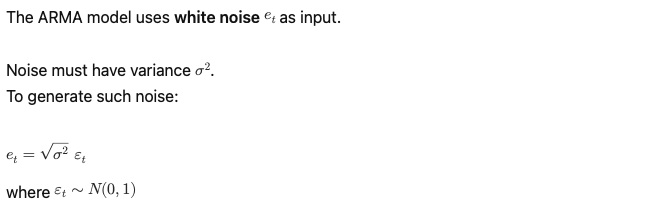

In [7]:
def simulate_ARMA(A, C, sigma2=1.5, N=300, buffer=100, seed=0):
    if seed is not None:
        np.random.seed(seed) # for reproducibility and debugging (to have same noise/outsput each time)

    # Generating Gaussian white noise with variance sigma2
    e = np.sqrt(sigma2) * np.random.randn(N + buffer)

    # Filter to simulate the ARMA process C(z)/A(z)
    y = signal.lfilter(C, A, e)

    return y[buffer:]


y1 = simulate_ARMA(A1, C1, sigma2=1.5, N=300, buffer=100, seed=0) #ARMA(2,2)
y2 = simulate_ARMA(A2, C2, sigma2=1.5, N=300, buffer=100, seed=1) #ARMA(1,2)

To simulate the ARMA process, I implemented a function that:
- Sets the random seed (so results are reproducible).
- Generates white noise with variance σ² using np.random.randn.
- Simulates the ARMA system by filtering the noise using

signal.lfilter(C, A, e), because lfilter computes


A(z)y = C(z)e.
- Removes the first 100 samples, since the AR part gives incorrect
initial values (initial conditions start at zero).

This produces a clean simulated ARMA time series.

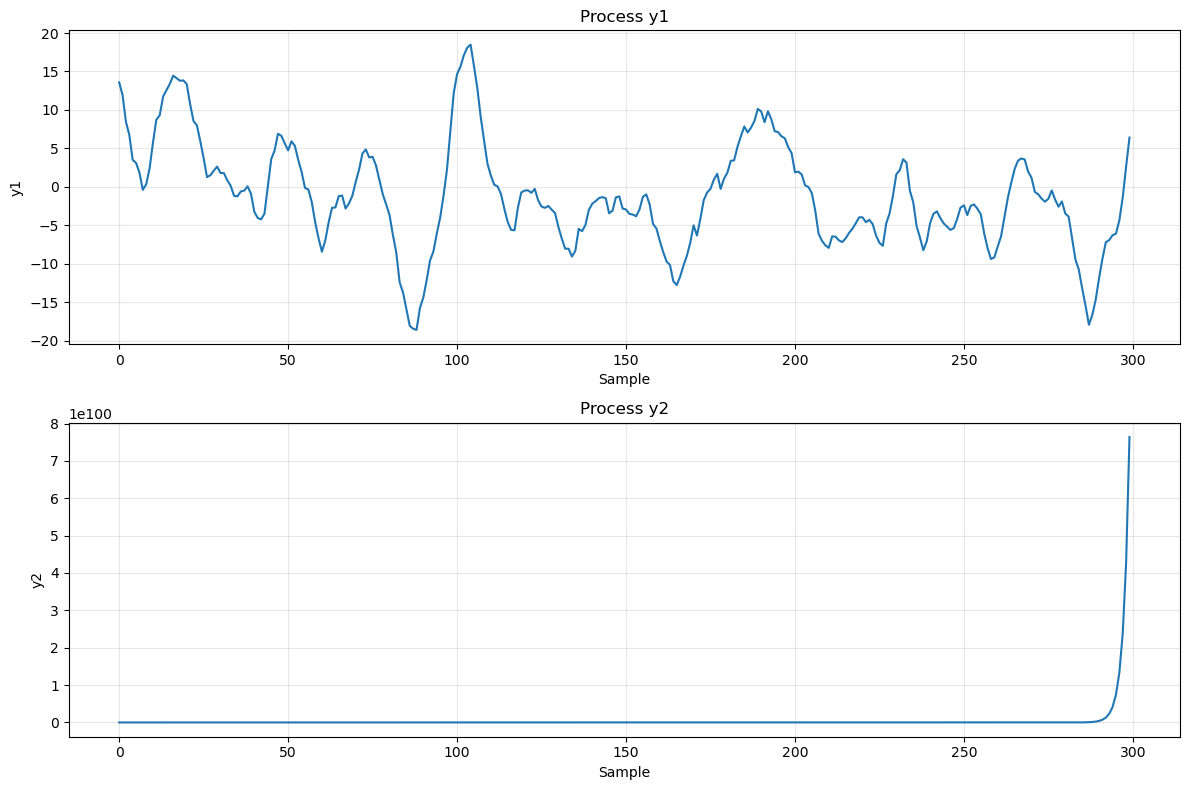

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(y1)
ax1.set_title('Process y1')
ax1.set_xlabel('Sample')
ax1.set_ylabel('y1')
ax1.grid(True, alpha=0.3)

ax2.plot(y2)
ax2.set_title('Process y2')
ax2.set_xlabel('Sample')
ax2.set_ylabel('y2')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analyzing the processes

As you can see, one of the processes diverges. Why is that? 

Plot the poles and zeros of the different polynomials to see if this provides a clue.

**QUESTION 1:** In Mozquizto, answer question 1.

-	Process y1 → looks normal, fluctuates around ±15
-	Process y2 → suddenly blows up to an insanely large value (10¹⁰⁰ !), its explodes/diverge because its AR polynomial is unstable. 

Process y2 diverges because the AR polynomial A2 has an unstable pole.
Specifically, the AR coefficient is 1.79, which violates the stability condition |a| < 1 for AR(1).
As a result, the recursion grows exponentially, and the simulated values explode.


Because the second process y2 uses C2, and when you compute its roots, one lies outside the unit circle → unstable MA polynomial.  The C2 polynomial is unstable.


The pole-zero map uses the **signal-processing stability convention**.
In this convention, poles must lie inside the unit circle for a stable filter.
Model y1 has poles inside the circle → stable.
Model y2 has a pole on or outside the circle → unstable → the simulated series diverges.
Note that this is the opposite of the usual time-series AR stability rule |a| < 1 because the **Z-transform inverts** the root locations.

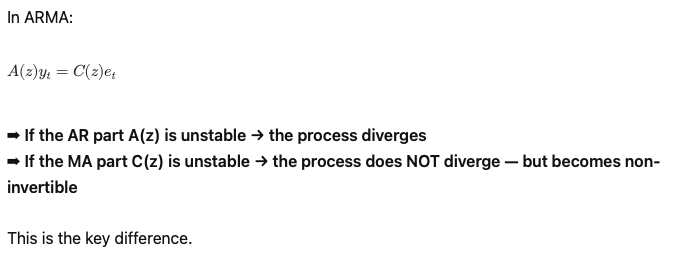

Only AR roots control divergence.

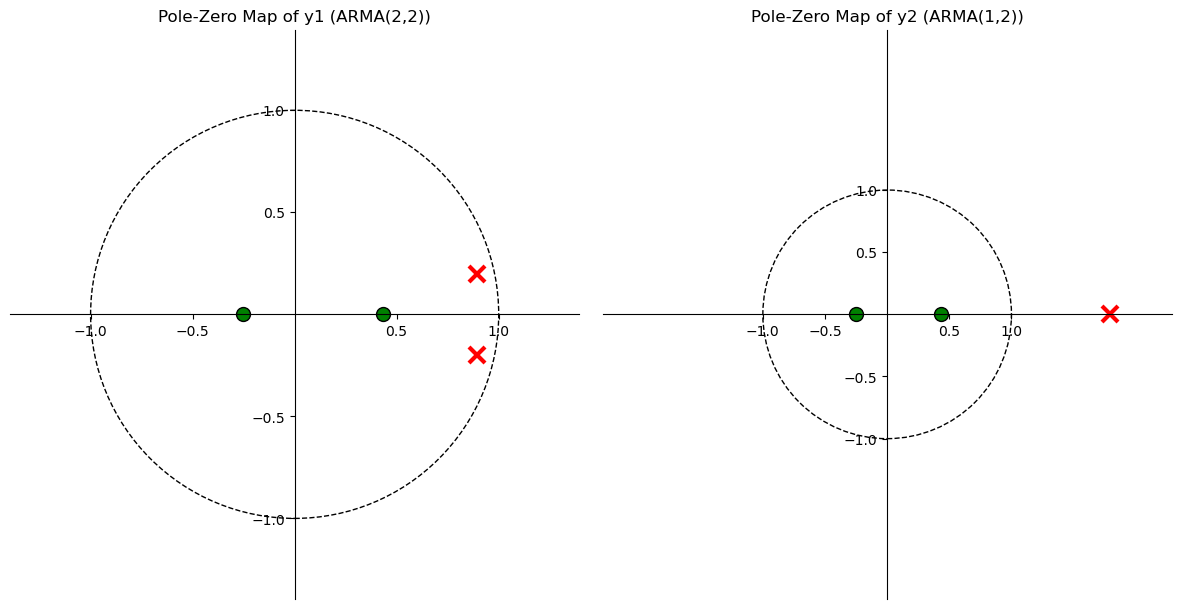

In [8]:
# Plot pole-zero maps to analyze why one process diverges
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
pzmap(C1, A1, ax=ax1, show=False)
ax1.set_title('Pole-Zero Map of y1 (ARMA(2,2))')

pzmap(C2, A2, ax=ax2, show=False)
ax2.set_title('Pole-Zero Map of y2 (ARMA(1,2))')

plt.tight_layout()
plt.show()


pole–zero map:
-  Poles = roots of A(z) = AR part (Red)
- Zeros = roots of C(z) = MA part (Green)

The unit circle is lfilter stable region.

-  Points inside the circle → stable.......AR (A-polynomial) is stable when all poles (green dots) are inside the unit circle
-  Points outside the circle → unstable........MA (C-polynomial) is invertible when all zeros (red crosses) are inside the unit circle

### Covariance function comparison

The theoretical covariance function $r_y(k)$ for an ARMA-process can be computed using the **Yule-Walker equations** using the provided function `kovarians`. 

The function assumes that the driving noise process has unit variance, i.e., $V(e(t)) = \sigma^2 = 1$. 

To instead compute the estimated covariance from a given data set, use the function `xcorr`.

Plot to compare the theoretical versus the estimated covariance for `y1` (set `m=20`).

**Why are the estimated and theoretical covariance functions not identical?**

**The theoretical covariance** assumes an infinite ARMA process (exact value for an infinite-length process).
**The estimated covariance** is computed from a finite simulated sample, which contains randomness and sampling variation.


Because of finite sample effects and randomness in the simulation, the curves differ.


**QUESTION 2:** In Mozquizto, answer question 2.

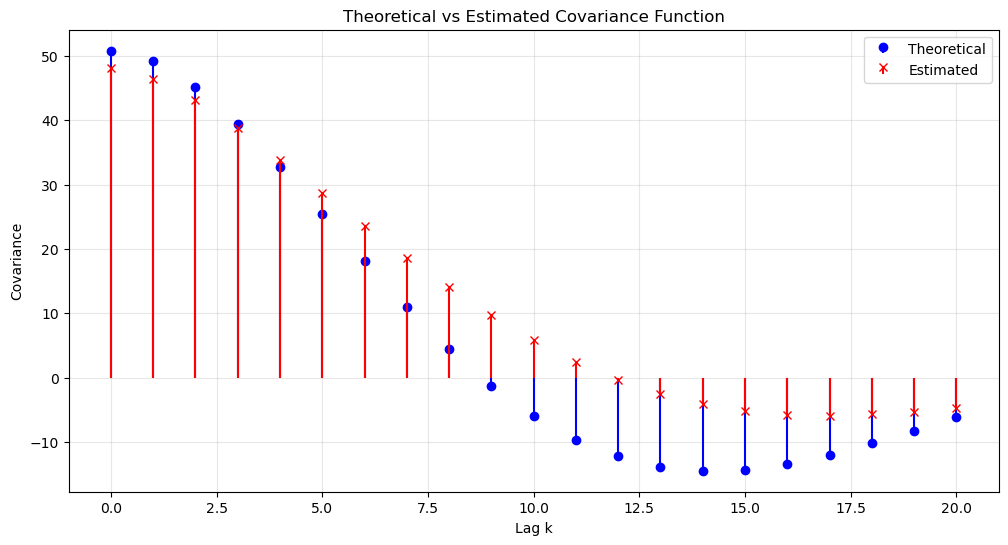

In [9]:
m = 20  # Number of lags to compute


sigma2 = 1.5
r_theo, tau = kovarians(C1, A1, m)
r_theo = r_theo * sigma2  # Scale by actual noise variance

# Compute estimated covariance from data using
lags, r_est = xcorr(y1, maxlag=m, biased=True)
r_est = r_est[m:]  

# Plot comparison
plt.figure(figsize=(12, 6))
plt.stem(tau, r_theo, linefmt='b-', markerfmt='bo', basefmt=' ', label='Theoretical')
plt.stem(tau, r_est, linefmt='r-', markerfmt='rx', basefmt=' ', label='Estimated')
plt.xlabel('Lag k')
plt.ylabel('Covariance')
plt.title('Theoretical vs Estimated Covariance Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

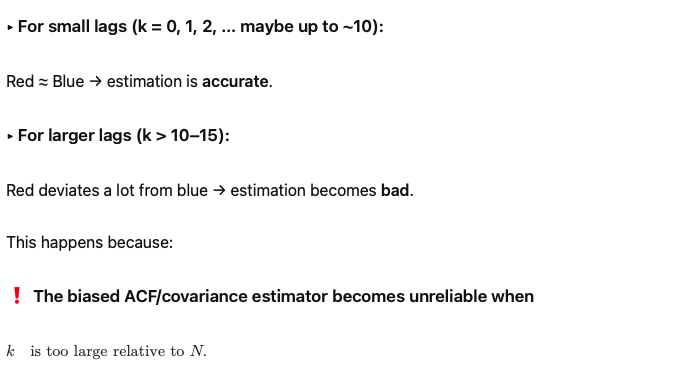
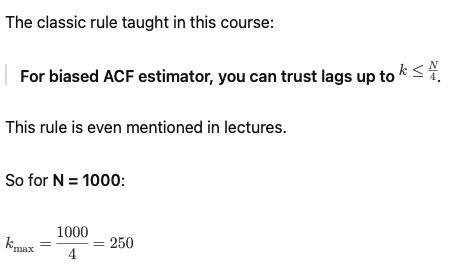

### Model estimation and validation

**Investigating the simulated series y₁ using ACF, PACF, and a normal probability plot.**

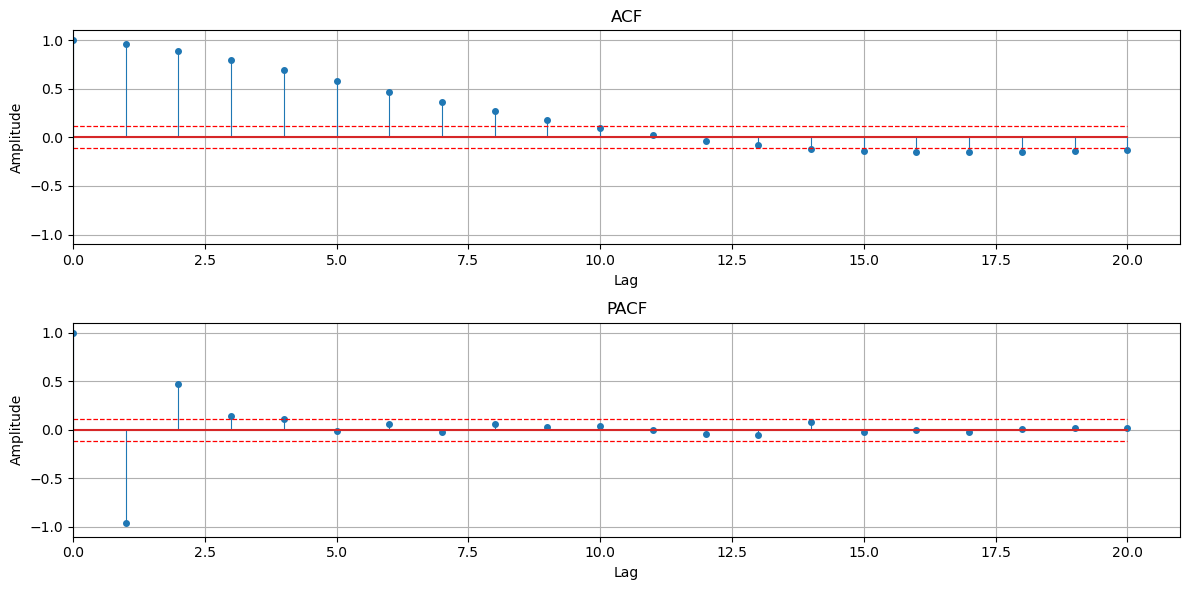

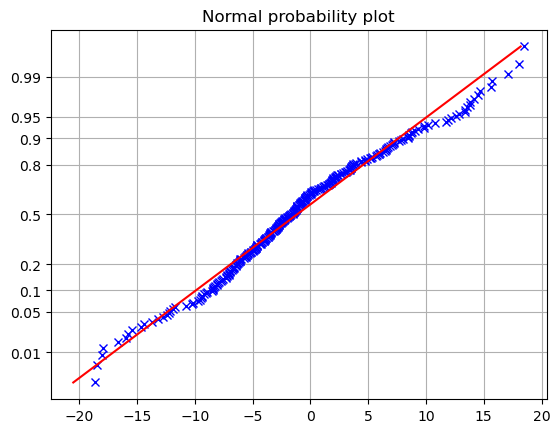

In [12]:
# Basic analysis of y1 using ACF, PACF, and normplot take a look on how plotACFnPACF() and normplot() is implemented in analysis.py: 
plotACFnPACF(y1)
normplot(y1)

How to use ACF in identification?

- Long decay → AR component is present
- No sudden cutoff → MA component is present OR sample noise

Combined → ARMA model feels right

So ACF supports that y₁ behaves like an ARMA process.

**(QQ-plot)**

This checks whether the data is normally distributed, especially the innovations.


- The plot is generally straight → the data is close to normal

- Some deviation at extreme points → expected because sample is finite

This matches the fact that the errors are Gaussian white noise.

### MODEL RESIDUAL COMPUTATION & INITIAL SAMPLE CORRUPTION

Estimate the model you wish to validate using the LS-based method for an AR($n_a$) model or using the ML-based method for an ARMA($n_a$, $n_c$) model. 

For estimation, Python uses the `estimateARMA` function which can estimate both AR and ARMA models by specifying the model orders.

To calculate the error residual of your estimated model, you can filter your data through the inverse filter of your model using:

```python
e_hat = signal.lfilter(model.A, model.C, y)
```

**Important:** An important thing to note when computing the residual using filtering is that the initial values of the output will be corrupted, as the AR part will need non-existing samples to initialise the first states, therefore setting these to zeros. 

This means that the first $n_a$ samples will be corrupted and should **always** be removed before **any** further processing is done.

Try changing the order of the $A(z)$ polynomial and plot the first 20 samples of `e_hat`. Can you see that the initial $n_a$ samples are corrupted? 

To avoid this from causing problems for you, you should **always** remove the first $n_a$ samples when filtering any process that you are modelling.

**Hint:** As you will do the filtering operation many times, and it is very easy to forget omitting these $n_a$ initial samples, it is highly recommended that you create your own function `my_filter` that does the filtering and omits the samples; that way you will not forget this. 

It is only a couple of lines of code, but it will likely save you a lot of pain... However, also note that there are cases when you do not want to do this automatically, especially in the case of prediction that we will cover later - in that case, you will filter two different sequences with different lengths - and then want omit the same number of samples as the longer filter for both sequences. In this case, you do **not** want to use `my_filter`.

In [12]:
def my_filter(A, C, y):
    """
    Filter y through the inverse ARMA model A(z)/C(z)
    and remove the first n_a corrupted samples.
    """
    # Filter to get residuals/innovations e_hat
    e_hat = signal.lfilter(A, C, y)

    # Number of AR parameters (order of A)
    n_a = len(A) - 1

    # 3. Drop the first n_a corrupted samples
    return e_hat[n_a:]

To compute ARMA residuals, first i created a function my_filter(A, C, y) that first applies the inverse ARMA model A(z)/C(z) to the data using signal.lfilter(A, C, y) to obtain an estimate of the innovations e_t. Since the AR part requires unknown past samples, the first n_a = len(A) − 1 values of the output are corrupted, so the function removes these initial nₐ samples before returning the result.

We therefore remove these initial corrupted samples using a custom filtering function, ensuring that residuals are valid for model estimation and validation.

### Demonstration of Initial Sample Corruption

Let's examine the issue with initial sample corruption when filtering. 

We'll compare filtering with and without removing the initial corrupted samples. Notice that the initial residuals are high.

To compute ARMA residuals, we filter the data through the inverse model A(z)/C(z).
However, the AR part requires past samples that don’t exist at the start of the series, so the first nₐ values are corrupted.
We therefore remove these initial corrupted samples using a custom filtering function, ensuring that residuals are valid for model estimation and validation.

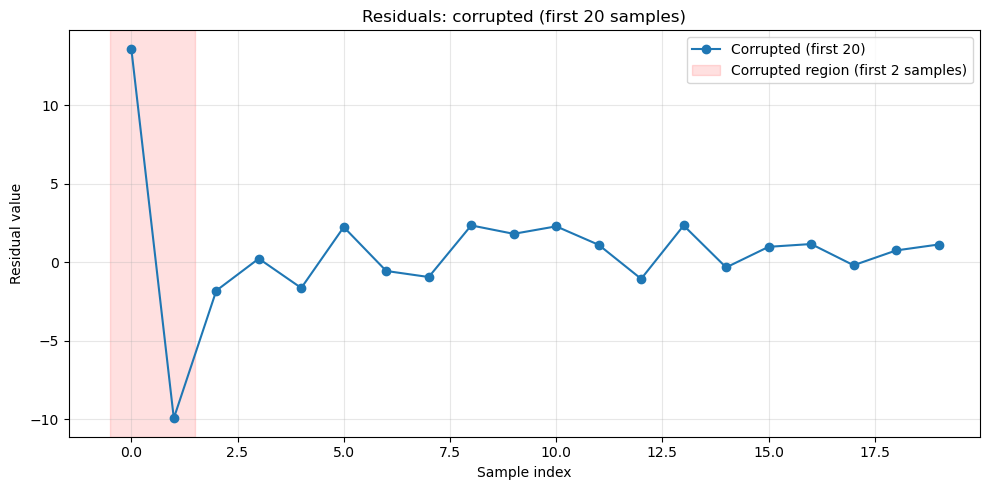

In [13]:
A_demo = np.array([1, -1.79, 0.84])
C_demo = np.array([1, -0.18, -0.11])

e_hat_corrupted = signal.lfilter(A_demo, C_demo, y1)

e_hat_clean = my_filter(A_demo, C_demo, y1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(20), e_hat_corrupted[:20], 'o-', markersize=6, color='C0', label='Corrupted (first 20)')
na = len(A_demo) - 1
plt.axvspan(-0.5, na - 0.5, alpha=0.12, color='red', label=f'Corrupted region (first {na} samples)')
plt.xlabel('Sample index')
plt.ylabel('Residual value')
plt.title('Residuals: corrupted (first 20 samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


After you estimate ARMA model:

Residuals measure how much of the data is left unexplained by the model.
A good ARMA model leaves residuals that look like pure white noise.

First I filtered the data using an **ARMA inverse filter.**
**
-  AR filters always need past values (like y[-1], y[-2]…) to compute the new values.
-  But when the signal starts at sample 0, those past values don’t exist.

So Python pretend those past values are 0.

That creates fake, incorrect values at the start of the filtered signal — these are called “Corrupted initial samples”

**Why does corruption happen?**

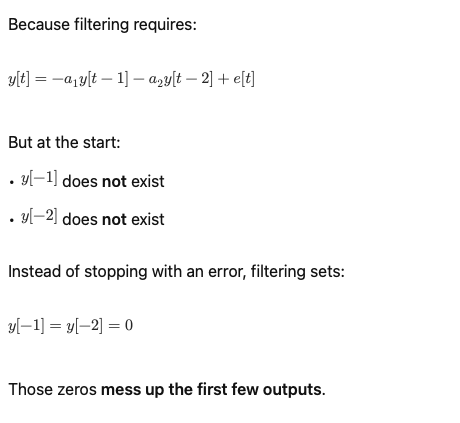

Look at the shaded pink region:
	•	That region shows the first n_a samples
	•	These are wrong
	•	They do not represent true residuals
	•	They must be removed before analysis or model estimation

Then the blue dots afterward:
	•	These are the correct residuals
	•	You can trust these values

what is the entire point of this section?

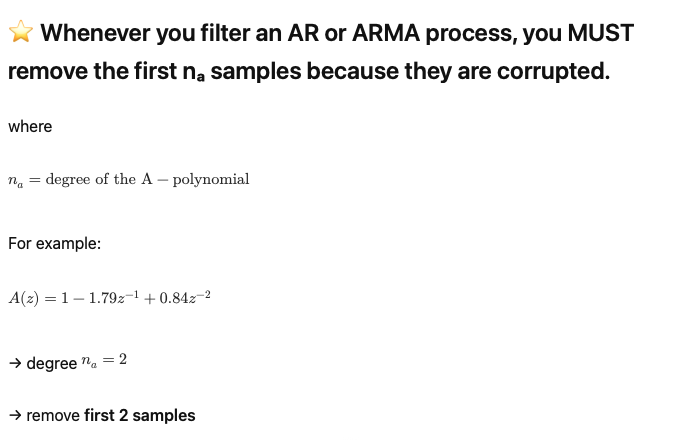

### Finding the appropriate model order

Proceed to find an appropriate model for the process by adding one extra parameter at a time, and then analyze the residual using ACF, PACF, and normplot. 

Make a note of the FPE for each of the models you examine. Is the FPE minimized for the correct model order?

AR(1) - A: [ 1.         -0.96680164], FPE: 2.6812

AR(1) Residual Analysis:


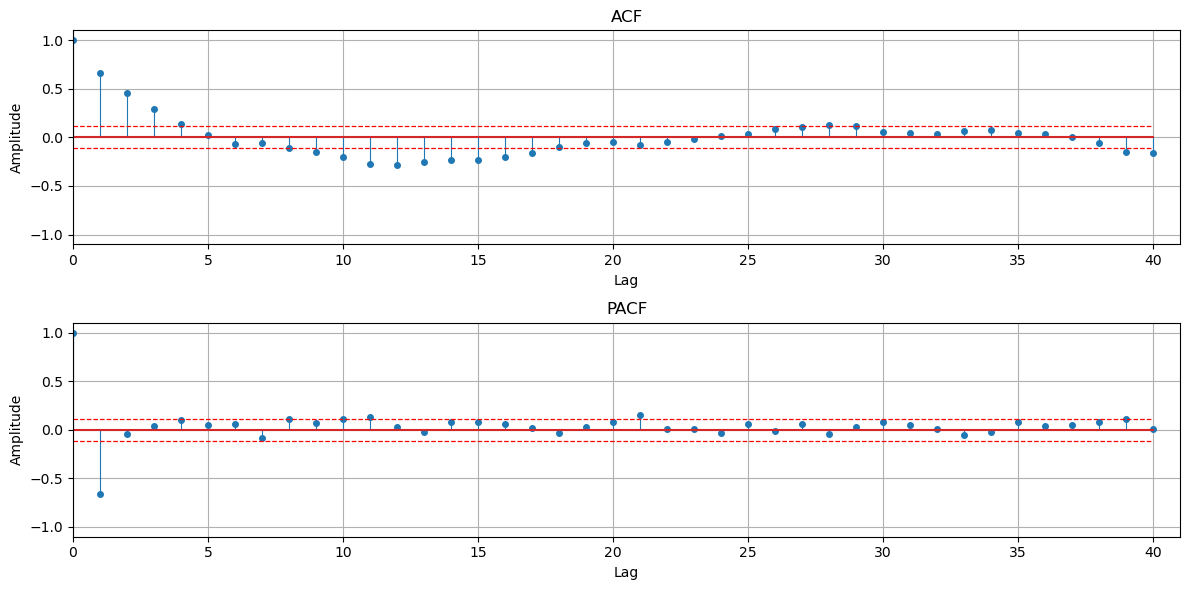

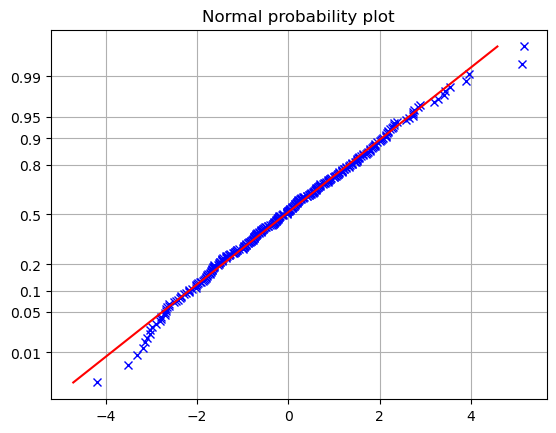

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 379.84 < 37.65)
  McLeod-Li test:        False (white if 117.44 < 37.65)
  Monti test:            False (white if 171.09 < 37.65)
  Sign change test:      False (white if 0.24 in [0.44,0.56])


In [25]:
# Estimate AR model different orders

ar1_model = estimateARMA(y1, A=1, C=0, plot=False)
e_hat_ar1 = my_filter(ar1_model.A, ar1_model.C, y1)
print(f"AR(1) - A: {ar1_model.A}, FPE: {ar1_model.FPE:.4f}\n")

# ----- AR(1) model ----- residuals (best AR model based on PACF)
print("AR(1) Residual Analysis:")
plotACFnPACF(e_hat_ar1, noLags=40, signLvl=0.05)
normplot(e_hat_ar1)
whiteness_test(e_hat_ar1, alpha=0.05)

# test What AR order (AR(1), AR(2), AR(3), …) is a good model for this data?


COMPREHENSIVE MODEL COMPARISON FOR y1

### TESTING AR MODELS ###
AR(1): FPE = 2.681193
AR(2): FPE = 1.445996
AR(3): FPE = 1.427155
AR(4): FPE = 1.435135
AR(5): FPE = 1.440934

### TESTING ARMA MODELS ###
ARMA(1,1): FPE = 1.987141
ARMA(1,2): FPE = 1.873317
ARMA(1,3): FPE = 1.746570
ARMA(2,1): FPE = 1.449787
ARMA(2,2): FPE = 1.448491
ARMA(2,3): FPE = 1.447854
ARMA(3,1): FPE = 1.432878
ARMA(3,2): FPE = 1.423786
ARMA(3,3): FPE = 1.429519

MINIMUM FPE: ARMA(3,2) with FPE = 1.42

Best model: ARMA(3,2)
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.931(±0.1659)·z⁻¹ - 0.6336(±0.2624)·z⁻² + 0.6414(±0.1198)·z⁻³
C(z) = 1.0 + 0.6424(±0.1698)·z⁻¹ - 0.1996(±0.0744)·z⁻²

Polynomial orders: nA = 3    nC = 2
Number of free coefficients: 5
Fit to estimation data (NRMSE): 82.83%
FPE : 1.424  MSE : 1.379
AIC : 948.38   BIC : 966.849


Residual Analysis for ARMA(3,2):


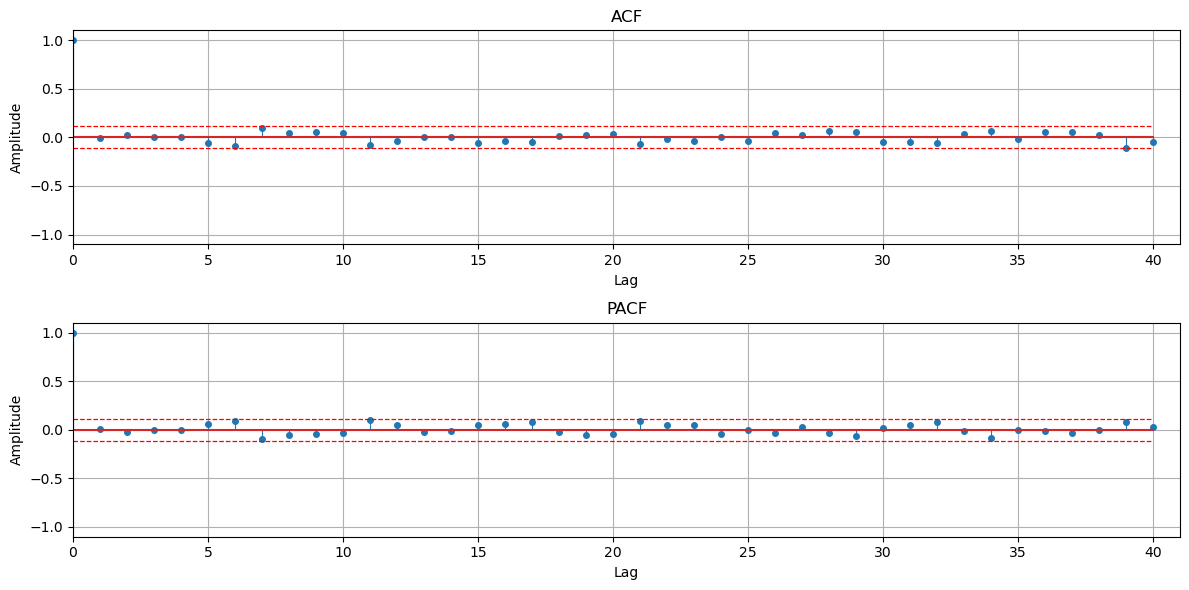

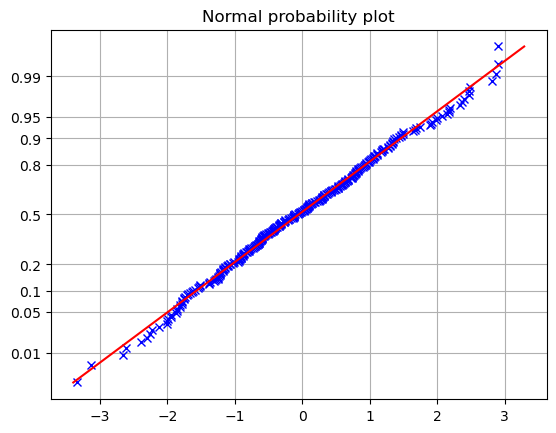

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 16.14 < 37.65)
  McLeod-Li test:        True (white if 19.29 < 37.65)
  Monti test:            True (white if 23.06 < 37.65)
  Sign change test:      True (white if 0.50 in [0.44,0.56])


In [ ]:
# Comprehensive model comparison - testing multiple AR and ARMA structures
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON FOR y1")
print("="*80)

# Dictionary to store all results
all_models = {}

# Test AR models (1 to 5)
print("\n### TESTING AR MODELS ###")
for p in range(1, 6):
    model = estimateARMA(y1, A=p, C=0, plot=False)
    e_hat = my_filter(model.A, model.C, y1)
    all_models[f'AR({p})'] = {'model': model, 'FPE': model.FPE, 'residuals': e_hat}
    print(f"AR({p}): FPE = {model.FPE:.6f}")

# Test ARMA models (combinations of p=1,2,3 and q=1,2,3)
print("\n### TESTING ARMA MODELS ###")
for p in range(1, 4):
    for q in range(1, 4):
        model = estimateARMA(y1, A=p, C=q, plot=False)
        e_hat = my_filter(model.A, model.C, y1)
        all_models[f'ARMA({p},{q})'] = {'model': model, 'FPE': model.FPE, 'residuals': e_hat}
        print(f"ARMA({p},{q}): FPE = {model.FPE:.6f}")

# Find the model with minimum FPE
min_model_name = min(all_models.keys(), key=lambda k: all_models[k]['FPE'])
min_fpe = all_models[min_model_name]['FPE']

print("\n" + "="*80)
print(f"MINIMUM FPE: {min_model_name} with FPE = {min_fpe:.2f}")
print("="*80)

# Display best model details
print(f"\nBest model: {min_model_name}")
best_model = all_models[min_model_name]['model']
best_model.summary()

# Analyze residuals of best model
print(f"\nResidual Analysis for {min_model_name}:")
best_residuals = all_models[min_model_name]['residuals']
plotACFnPACF(best_residuals, noLags=40, signLvl=0.05)
normplot(best_residuals)
whiteness_test(best_residuals, alpha=0.05)

The ARMA(3,2) model has MORE parameters

→ It can bend and adapt to noise better

→ So it can slightly reduce prediction error (FPE)

Even if a more complicated model has a slightly better FPE, you must choose the model that:
-  has white residuals
-  has low complexity
-  aligns with AIC/BIC
-  makes sense statistically.

### Estimating ARMA Models (ARMA(1,1))

Now let's estimate ARMA models with different combinations of $n_a$ and $n_c$ from 1 to 3

Estimating ARMA(1,1)...
ARMA(1,1) - A: [ 1.         -0.94598834], C: [1.         0.44292983]
FPE: 1.9871

ARMA(1,1) Residual Analysis:


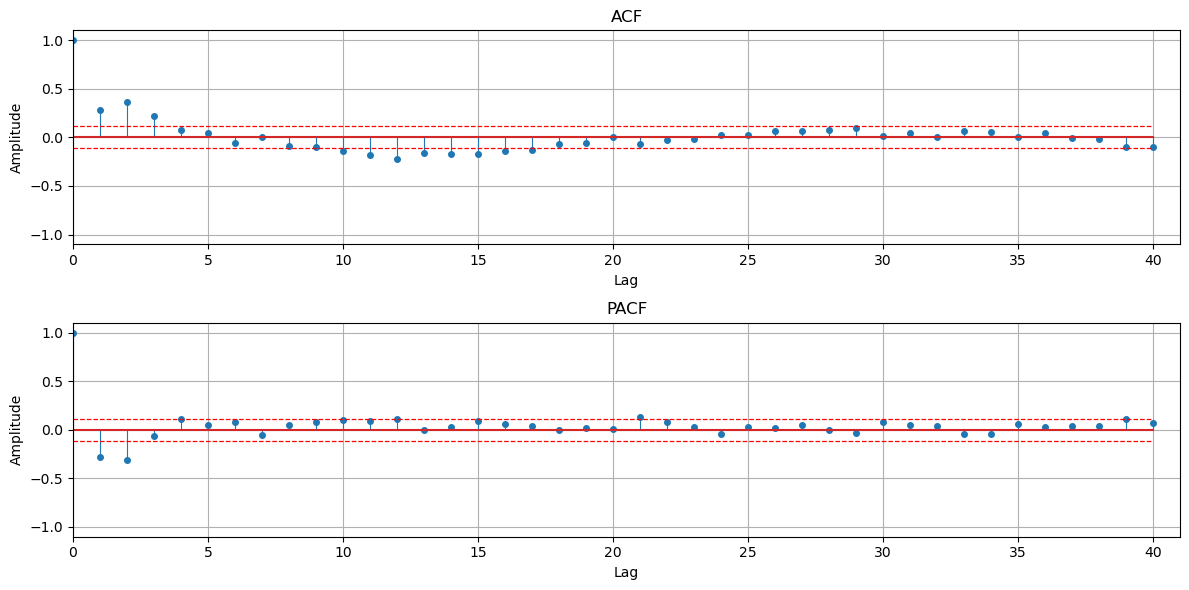

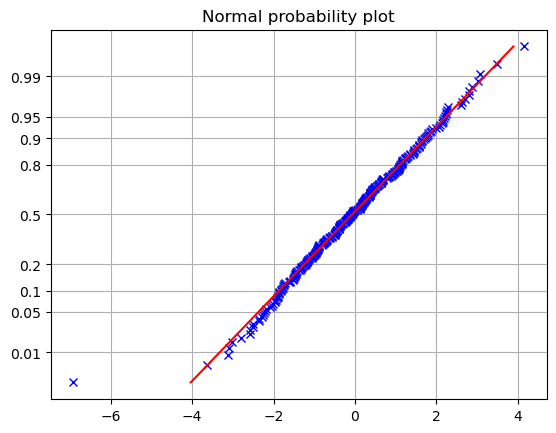

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 161.53 < 37.65)
  McLeod-Li test:        True (white if 11.68 < 37.65)
  Monti test:            False (white if 86.80 < 37.65)
  Sign change test:      False (white if 0.39 in [0.44,0.56])


In [29]:
# Estimate ARMA model 

# ARMA(1,1)
print("Estimating ARMA(1,1)...")
arma11_model = estimateARMA(y1, A=1, C=1, plot=False)
e_hat_arma11 = my_filter(arma11_model.A, arma11_model.C, y1)
print(f"ARMA(1,1) - A: {arma11_model.A}, C: {arma11_model.C}")
print(f"FPE: {arma11_model.FPE:.4f}\n")

# Analyze ARMA(1,1) residuals
print("ARMA(1,1) Residual Analysis:")
plotACFnPACF(e_hat_arma11, noLags=40, signLvl=0.05)
normplot(e_hat_arma11)
whiteness_test(e_hat_arma11, alpha=0.05)

# test other ARMA models


### Examination Question 3 - Final Conclusion for Model Order Selection

**QUESTION 3:** In Mozquizto, answer question 3.


Using the FPE criterion, I compared AR models (orders 1–5) and ARMA(p, q) models with p, q ∈ {1, 2, 3}.
The model with the smallest FPE was:

ARMA(3,2) with FPE ≈ 1.42.

Johan also got $FPE \approx 1.42$ for and $AR(3)$ model. Neither correspond correctly to the $ARMA(2, 2)$. 

Residual diagnostics (ACF/PACF, normal plot, whiteness tests) showed no significant autocorrelation, normally distributed innovations, and the whiteness hypothesis was not rejected.

Therefore:

ARMA(3,2) is the appropriate model for y1.

## 2.2 Model order estimation of an ARMA-process

In the file `data.dat` you will find 200 observations of the ARMA(1,1)-process

$$y_t - 0.6 y_{t-1} = e_t + 0.8 e_{t-1}$$

Assuming that you do not know what might be an appropriate model structure for the process, we will begin by trying to estimate it using an AR($p$) model, for $p=1,\ldots,5$. 

When examining which model order to use, see the parameter estimates and some statistics. 

Try modelling data as an AR($p$) model, for $p=1,\ldots,5$.

Data shape: (200,)
Number of observations: 200


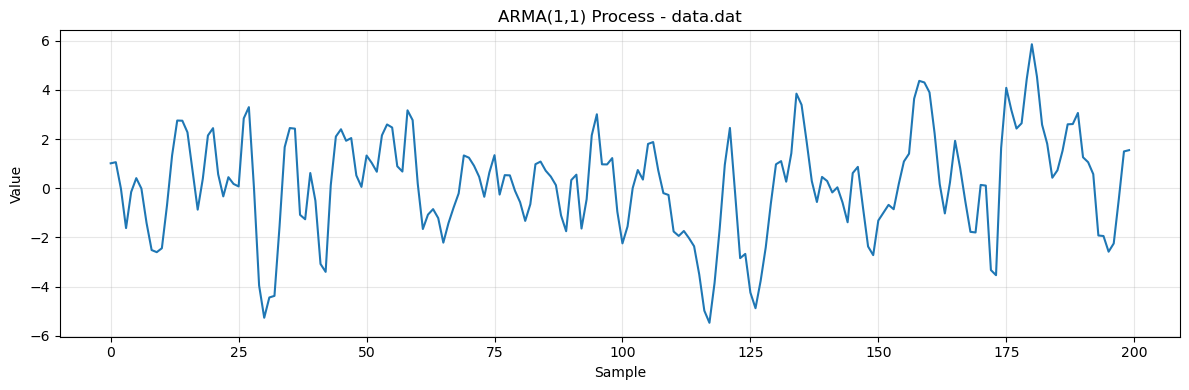

In [8]:
# Load the data from data.dat
data = np.loadtxt('data/data.dat')
orig_noise = np.loadtxt('data/noise.dat')

print(f"Data shape: {data.shape}")
print(f"Number of observations: {len(data)}")

# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(data)
plt.title('ARMA(1,1) Process - data.dat')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Try AR($p$) models for $p = 1, \ldots, 5$

To get useful information about the model, try using `.summary()`.

AR(1) Model
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.7723(±0.0451)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 36.13%
FPE : 1.772  MSE : 1.755
AIC : 678.674   BIC : 681.968


AR(1) Residual Analysis:


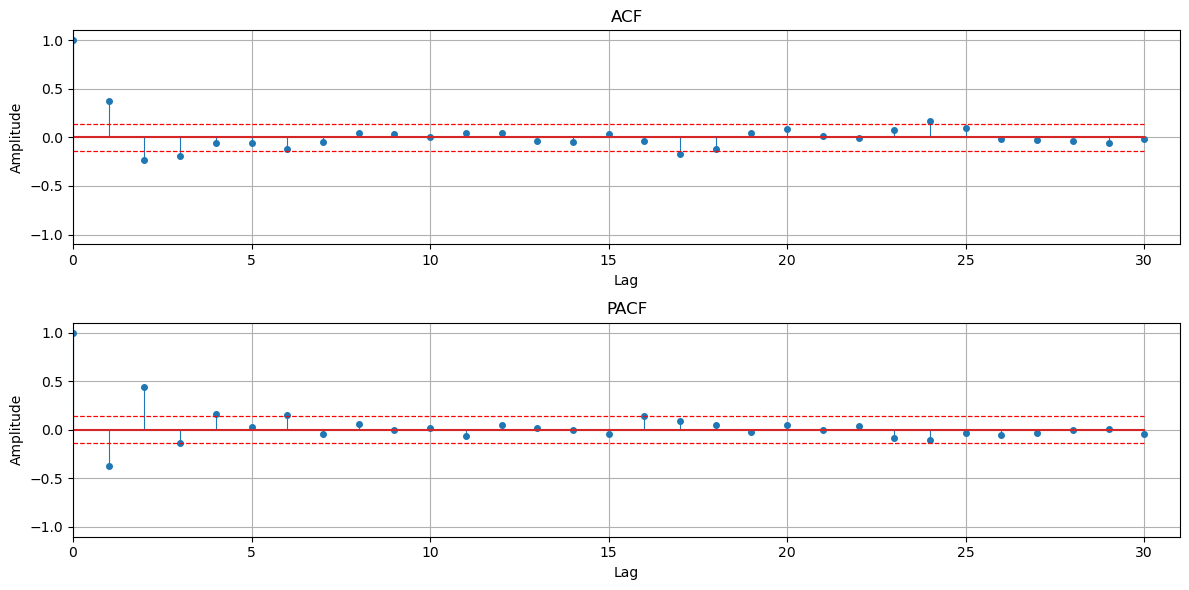

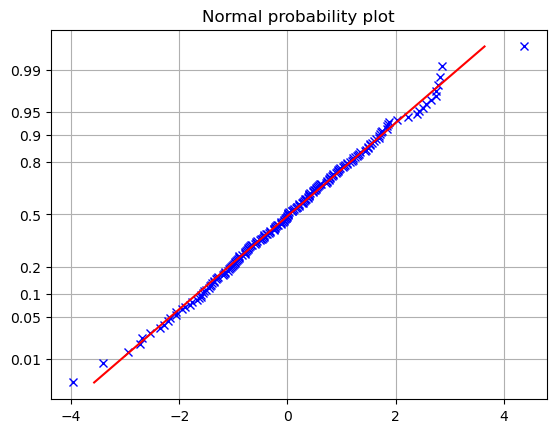

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 76.80 < 37.65)
  McLeod-Li test:        True (white if 26.01 < 37.65)
  Monti test:            False (white if 96.68 < 37.65)
  Sign change test:      False (white if 0.36 in [0.43,0.57])


AR(2) Model
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.1466(±0.0621)·z⁻¹ + 0.4861(±0.0621)·z⁻²

Polynomial orders: nA = 2
Number of free coefficients: 2
Fit to estimation data (NRMSE): 44.03%
FPE : 1.373  MSE : 1.347
AIC : 624.947   BIC : 631.524


AR(2) Residual Analysis:


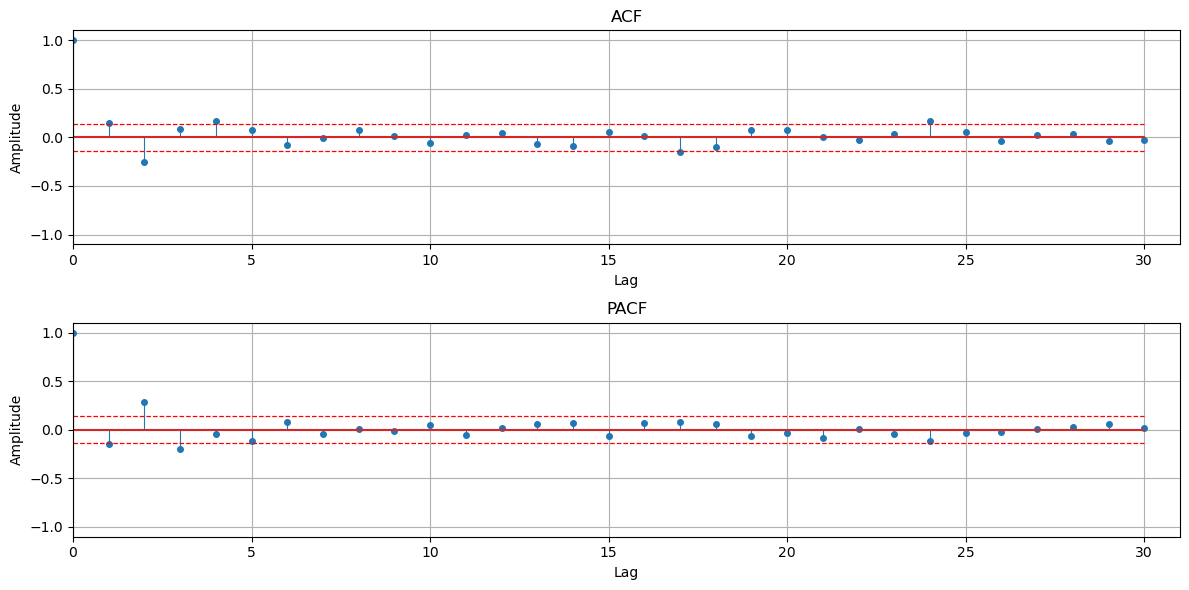

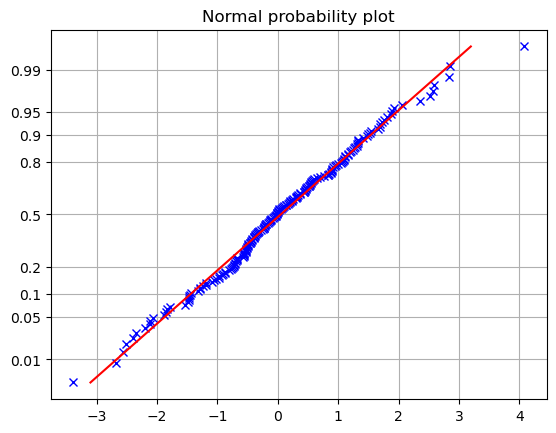

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 50.14 < 37.65)
  McLeod-Li test:        True (white if 26.38 < 37.65)
  Monti test:            False (white if 47.11 < 37.65)
  Sign change test:      True (white if 0.45 in [0.43,0.57])


AR(3) Model
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.2952(±0.0678)·z⁻¹ + 0.8365(±0.098)·z⁻² - 0.306(±0.0681)·z⁻³

Polynomial orders: nA = 3
Number of free coefficients: 3
Fit to estimation data (NRMSE): 46.62%
FPE : 1.262  MSE : 1.226
AIC : 605.172   BIC : 615.022


AR(3) Residual Analysis:


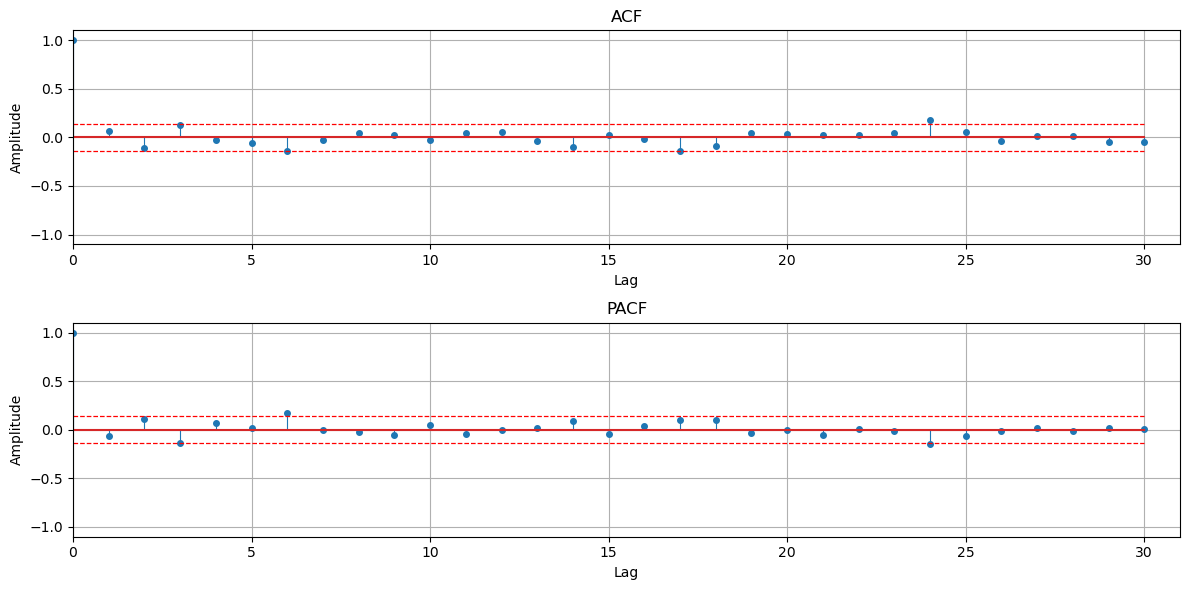

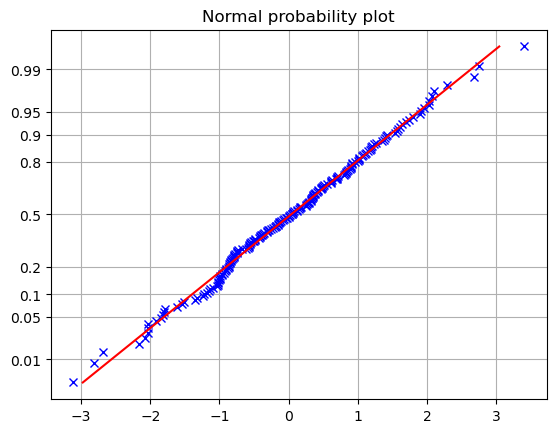

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 29.98 < 37.65)
  McLeod-Li test:        True (white if 20.36 < 37.65)
  Monti test:            True (white if 29.04 < 37.65)
  Sign change test:      True (white if 0.46 in [0.43,0.57])


AR(4) Model
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.3593(±0.0695)·z⁻¹ + 1.015(±0.1117)·z⁻² - 0.5902(±0.1118)·z⁻³ + 0.221(±0.0698)·z⁻⁴

Polynomial orders: nA = 4
Number of free coefficients: 4
Fit to estimation data (NRMSE): 47.91%
FPE : 1.213  MSE : 1.167
AIC : 594.522   BIC : 607.635


AR(4) Residual Analysis:


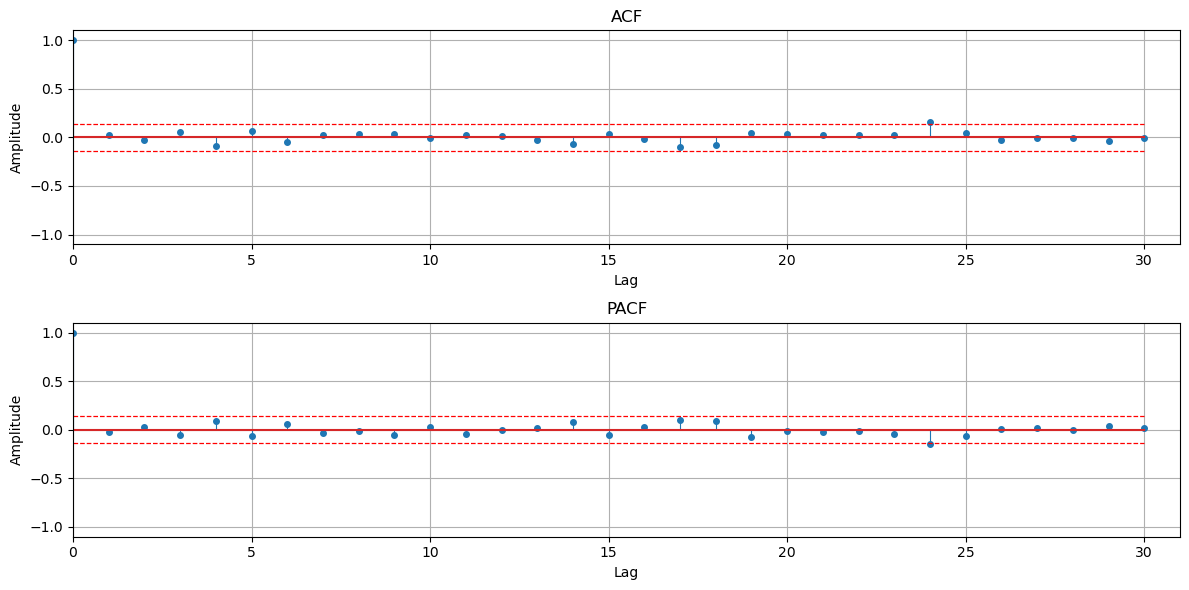

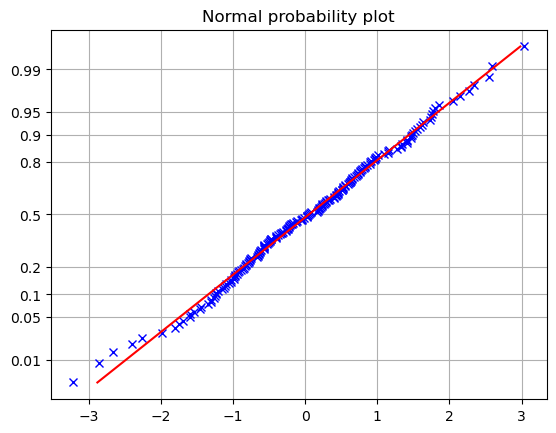

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 16.24 < 37.65)
  McLeod-Li test:        True (white if 18.19 < 37.65)
  Monti test:            True (white if 19.55 < 37.65)
  Sign change test:      True (white if 0.47 in [0.43,0.57])


AR(5) Model
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.3793(±0.071)·z⁻¹ + 1.0545(±0.1189)·z⁻² - 0.6496(±0.1325)·z⁻³ + 0.3027(±0.1189)·z⁻⁴ - 0.0596(±0.0713)·z⁻⁵

Polynomial orders: nA = 5
Number of free coefficients: 5
Fit to estimation data (NRMSE): 48.18%
FPE : 1.215  MSE : 1.155
AIC : 591.534   BIC : 607.899


AR(5) Residual Analysis:


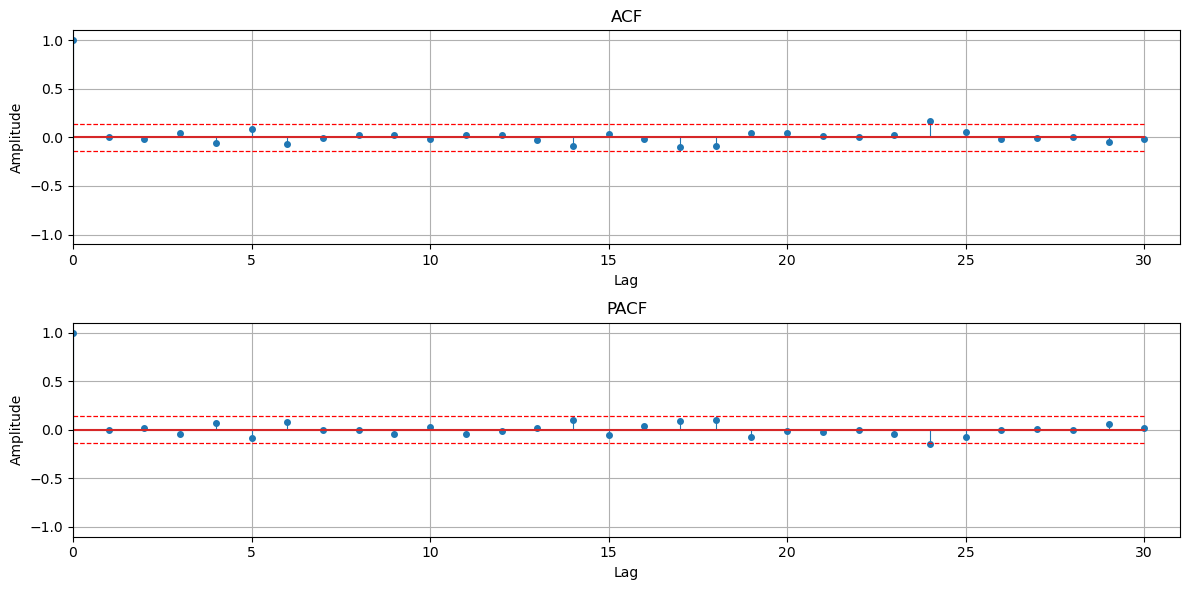

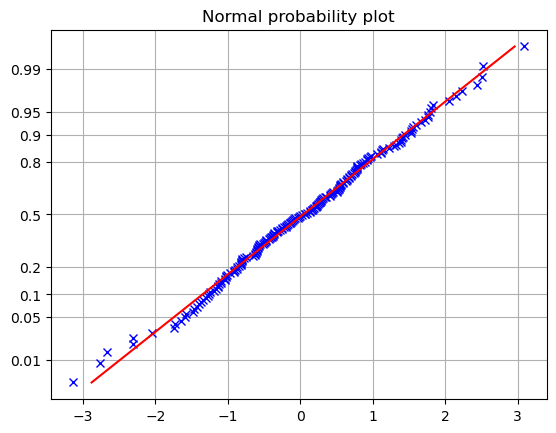

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 18.15 < 37.65)
  McLeod-Li test:        True (white if 20.03 < 37.65)
  Monti test:            True (white if 20.01 < 37.65)
  Sign change test:      True (white if 0.48 in [0.43,0.57])


FPE COMPARISON FOR AR MODELS
AR(1): FPE = 1.771601
AR(2): FPE = 1.372740
AR(3): FPE = 1.262476
AR(4): FPE = 1.213285
AR(5): FPE = 1.214590


In [16]:
# Test AR(p) models for p = 1, 2, 3, 4, 5
# Store results for comparison
ar_models = {}

for p in range(1, 6):
    print("=" * 60)
    print(f"AR({p}) Model")
    print("=" * 60)
    
    # Estimate AR(p) model
    model = estimateARMA(data, A=p, C=0, plot=False)
    model.summary()
    
    # Compute residuals
    e_hat = my_filter(model.A, model.C, data)
    
    # Store results
    ar_models[p] = {'model': model, 'FPE': model.FPE, 'residuals': e_hat}
    
    # Analyze residuals
    print(f"\nAR({p}) Residual Analysis:")
    plotACFnPACF(e_hat, noLags=30, signLvl=0.05)
    normplot(e_hat)
    whiteness_test(e_hat, alpha=0.05)
    print("\n")

# Summary of FPE values
print("=" * 60)
print("FPE COMPARISON FOR AR MODELS")
print("=" * 60)
for p in range(1, 6):
    print(f"AR({p}): FPE = {ar_models[p]['FPE']:.6f}")
print("=" * 60)

### Examination Question 4

**In Mozquizto, answer question 4.**

-	AR(1) → AR(2): big improvement
-	AR(2) → AR(3): big improvement
-	AR(3) → AR(4): small improvement
-	AR(4) → AR(5): almost no improvement (1.218 → 1.214)

. Conclusion

The lowest AR order that models the process well is:

p = 3

### Try ARMA($p,q$) models

Instead, try to model the data using ARMA($p,q$) models, for $p,q = 1, 2$.

ARMA(1,1) Model
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.5815(±0.0618)·z⁻¹
C(z) = 1.0 + 0.7637(±0.0492)·z⁻¹

Polynomial orders: nA = 1    nC = 1
Number of free coefficients: 2
Fit to estimation data (NRMSE): 48.09%
FPE : 1.182  MSE : 1.159
AIC : 598.115   BIC : 604.702


ARMA(1,1) Residual Analysis:


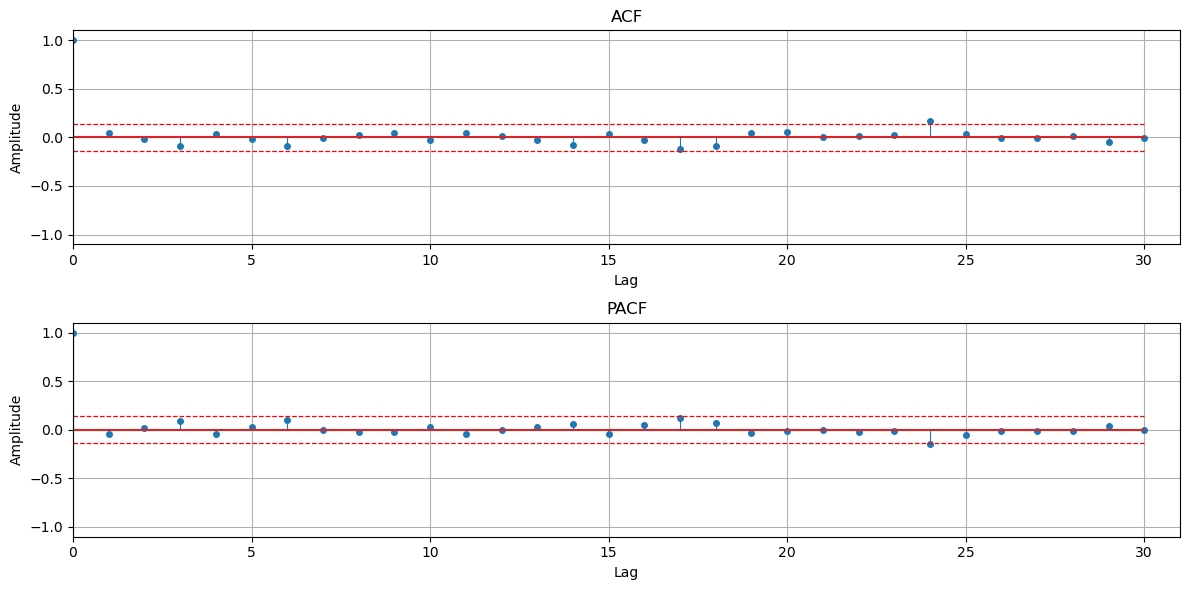

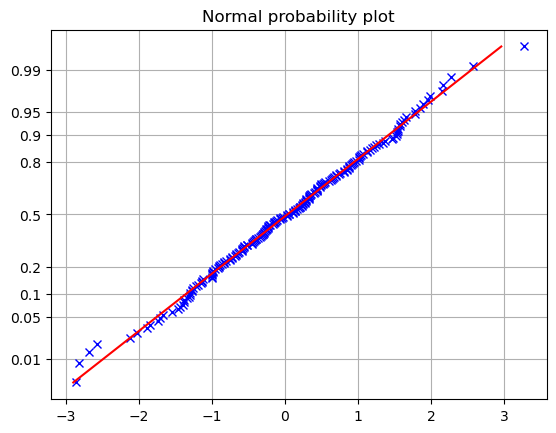

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.88 < 37.65)
  McLeod-Li test:        True (white if 21.87 < 37.65)
  Monti test:            True (white if 18.27 < 37.65)
  Sign change test:      True (white if 0.49 in [0.43,0.57])


ARMA(1,2) Model
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.4667(±0.1121)·z⁻¹
C(z) = 1.0 + 0.9169(±0.123)·z⁻¹ + 0.1738(±0.1162)·z⁻²

Polynomial orders: nA = 1    nC = 2
Number of free coefficients: 3
Fit to estimation data (NRMSE): 48.35%
FPE : 1.182  MSE : 1.148
AIC : 598.128   BIC : 608.008


ARMA(1,2) Residual Analysis:


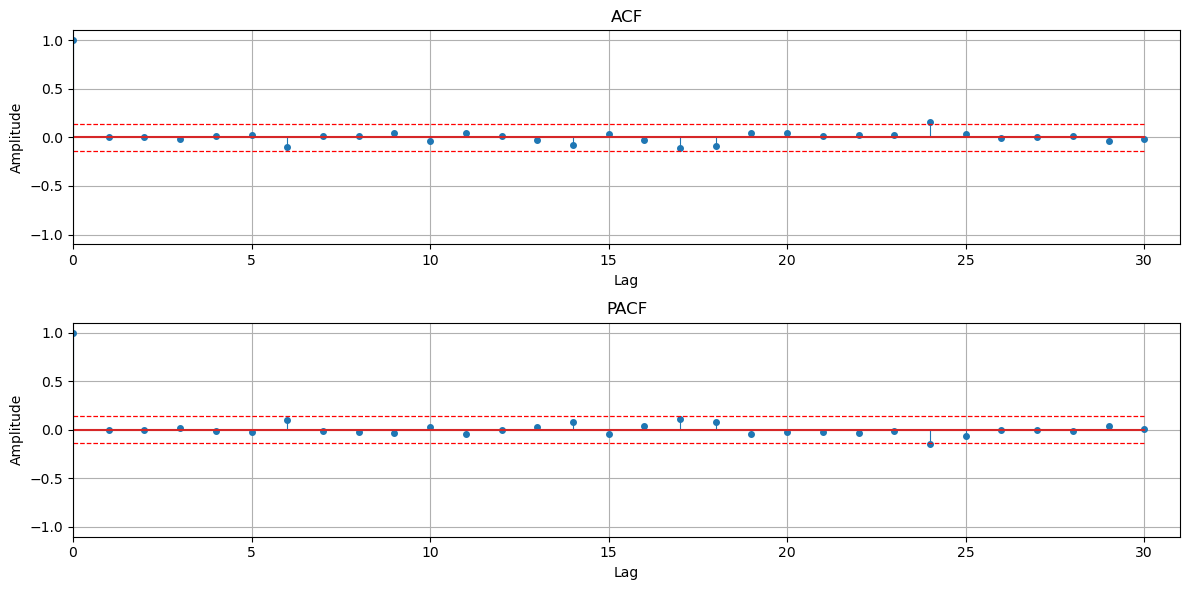

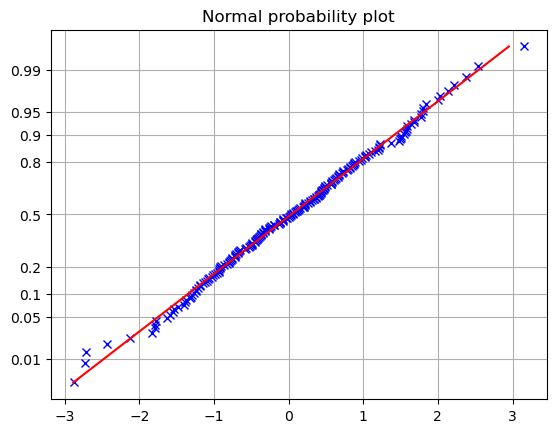

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 17.41 < 37.65)
  McLeod-Li test:        True (white if 23.87 < 37.65)
  Monti test:            True (white if 16.65 < 37.65)
  Sign change test:      True (white if 0.48 in [0.43,0.57])


ARMA(2,1) Model
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.6992(±0.0961)·z⁻¹ + 0.1425(±0.0924)·z⁻²
C(z) = 1.0 + 0.6887(±0.0729)·z⁻¹

Polynomial orders: nA = 2    nC = 1
Number of free coefficients: 3
Fit to estimation data (NRMSE): 48.25%
FPE : 1.186  MSE : 1.152
AIC : 595.944   BIC : 605.808


ARMA(2,1) Residual Analysis:


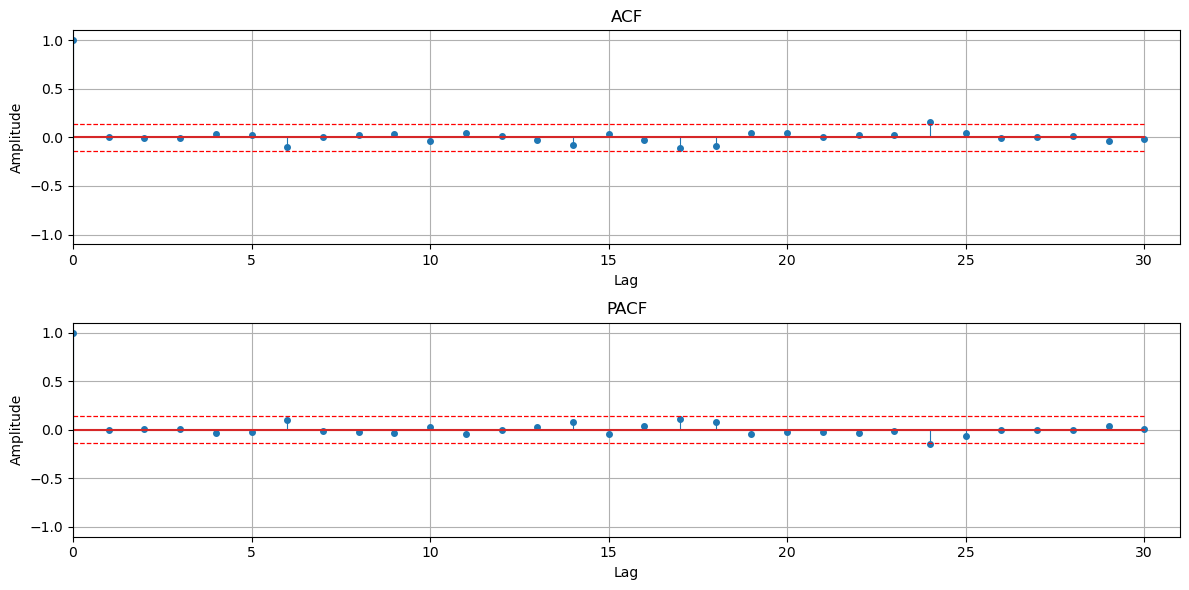

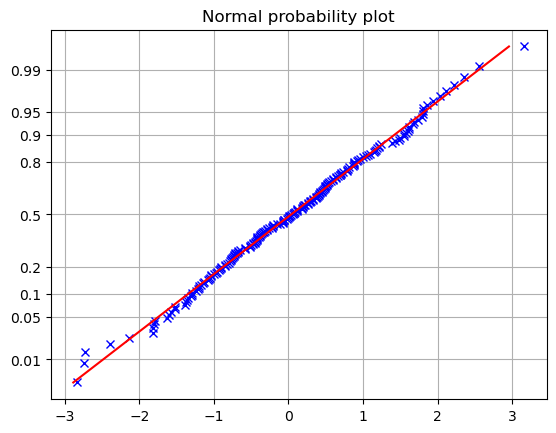

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 17.42 < 37.65)
  McLeod-Li test:        True (white if 24.48 < 37.65)
  Monti test:            True (white if 16.37 < 37.65)
  Sign change test:      True (white if 0.50 in [0.43,0.57])


ARMA(2,2) Model
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.6266(±0.6382)·z⁻¹ + 0.1014(±0.3811)·z⁻²
C(z) = 1.0 + 0.762(±0.6397)·z⁻¹ + 0.0585(±0.4867)·z⁻²

Polynomial orders: nA = 2    nC = 2
Number of free coefficients: 4
Fit to estimation data (NRMSE): 48.25%
FPE : 1.198  MSE : 1.152
AIC : 597.923   BIC : 611.076


ARMA(2,2) Residual Analysis:


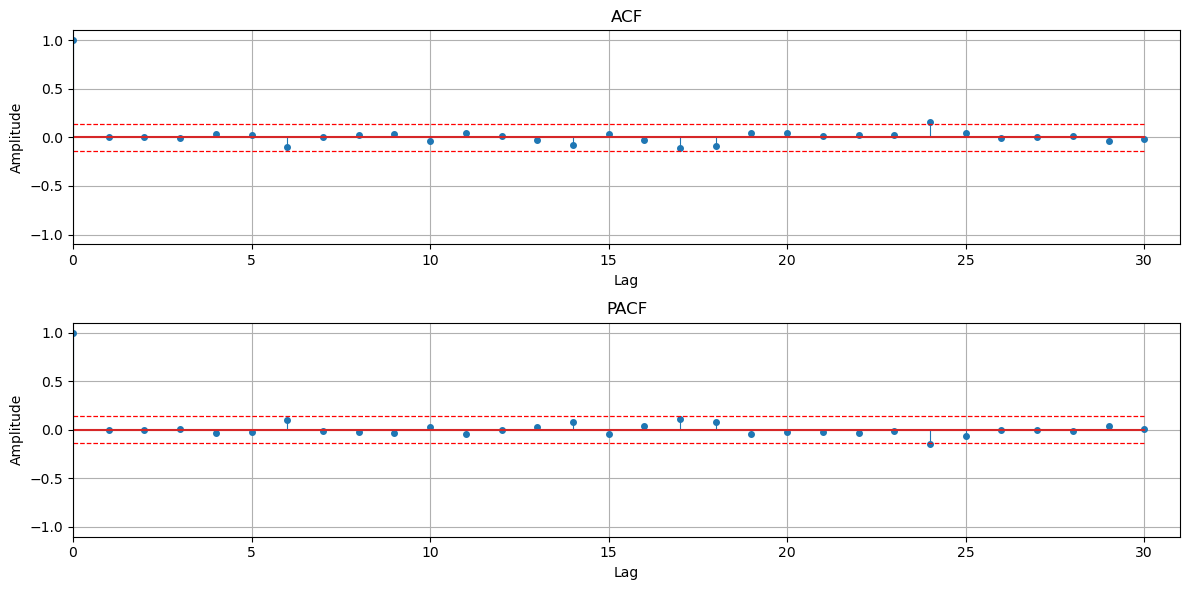

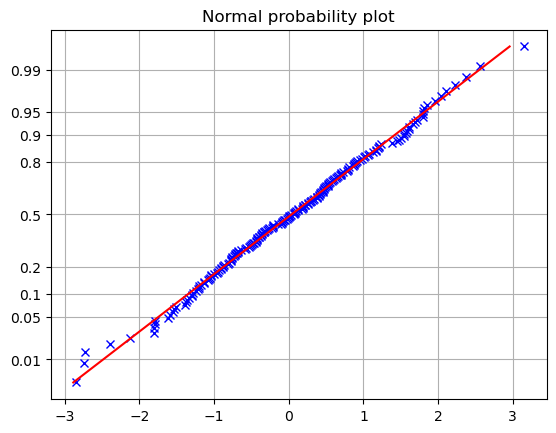

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 17.30 < 37.65)
  McLeod-Li test:        True (white if 24.43 < 37.65)
  Monti test:            True (white if 16.41 < 37.65)
  Sign change test:      True (white if 0.50 in [0.43,0.57])


COMPLETE FPE COMPARISON - ALL MODELS
AR(1): FPE = 1.771601
AR(2): FPE = 1.372740
AR(3): FPE = 1.262476
AR(4): FPE = 1.213285
AR(5): FPE = 1.214590
ARMA(1,1): FPE = 1.181614
ARMA(1,2): FPE = 1.181538
ARMA(2,1): FPE = 1.186254
ARMA(2,2): FPE = 1.198193
MINIMUM FPE: ARMA(1,2) with FPE = 1.18


In [36]:
# Test ARMA(p,q) models for p,q = 1, 2
# Store all results for comparison
arma_models = {}

for p in range(1, 3):
    for q in range(1, 3):
        print("=" * 60)
        print(f"ARMA({p},{q}) Model")
        print("=" * 60)
        
        # Estimate ARMA(p,q) model
        model = estimateARMA(data, A=p, C=q, plot=False)
        model.summary()
        
        # Compute residuals
        e_hat = my_filter(model.A, model.C, data)
        
        # Store results
        arma_models[f'ARMA({p},{q})'] = {'model': model, 'FPE': model.FPE, 'residuals': e_hat}
        
        # Analyze residuals
        print(f"\nARMA({p},{q}) Residual Analysis:")
        plotACFnPACF(e_hat, noLags=30, signLvl=0.05)
        normplot(e_hat)
        whiteness_test(e_hat, alpha=0.05)
        print("\n")

# Summary comparison of ALL models (AR and ARMA)
print("=" * 60)
print("COMPLETE FPE COMPARISON - ALL MODELS")
print("=" * 60)

# Combine AR and ARMA results
all_results = {}

# Add AR models
for p in range(1, 6):
    all_results[f'AR({p})'] = ar_models[p]['FPE']

# Add ARMA models
for key in arma_models:
    all_results[key] = arma_models[key]['FPE']

# Display all FPE values
for model_name, fpe in all_results.items():
    print(f"{model_name}: FPE = {fpe:.6f}")

# Find minimum
min_model = min(all_results.keys(), key=lambda k: all_results[k])
min_fpe = all_results[min_model]

print("=" * 60)
print(f"MINIMUM FPE: {min_model} with FPE = {min_fpe:.2f}")
print("=" * 60)

We tested AR and ARMA models using FPE and residual whiteness.
**The ARMA(1,2)** model gave the lowest FPE and all whiteness tests passed, so it is the best model according to these criteria.


**The true data-generating model was ARMA(1,1)**, but because we only have a finite sample, the slightly more flexible ARMA(1,2) model achieved a marginally better fit.

### Discussion: Model comparison

Comparing the models using the variance of the residuals, which was the best model of the ones you considered, i.e., an AR($p$), for $p=1,\ldots,5$, or an ARMA($p,q$), for $p,q = 1, 2$? 

Examine the ACF and PACF as well. 

Which model would you pick if you did not know it was an ARMA(1,1)?

**Be prepared to answer this question when discussing with the examiner at the computer exercise!**

To choose the best model, we compare:

1. FPE (Final Prediction Error)

Lower FPE → better generalization.

In our results, ARMA(1,2) has the lowest FPE ≈ 1.18.

Therefore ARMA(1,2) is the best among the tested models.

2. Residual Whiteness

A good model should have white-noise residuals (no autocorrelation left).

ARMA(1,2)’s residuals pass the whiteness tests (Ljung–Box, McLeod–Li, Monti, sign test).

This means the model captures all the structure in the data.

3. ACF and PACF of Residuals

Residual ACF/PACF for ARMA(1,2) show almost all spikes inside significance limits.

This means no additional AR or MA terms are needed.

**If we did not know the true model is ARMA(1,1), we would choose ARMA(1,2) based on**:

Lowest FPE

Good residual whiteness

Residuals with no remaining structure (ACF/PACF clean)

Even though the true model used to generate the data was ARMA(1,1), the sample size (only 200) and random noise make ARMA(1,2) look slightly better by FPE.

## 2.3 Estimation of a SARIMA-process

We proceed to examine the seasonal ARMA model

$$
A(z)\nabla_s y_t = C(z)e_t,
$$

with $\nabla_s = (1-z^{-s})$.

We begin with simulating data, and then use the ML-based estimator to re-estimate the parameters to see how this is done. Simulate the process using the following polynomials:

$$
A(z) = 1 - 1.5z^{-1} + 0.7z^{-2},
$$

$$
C(z) = 1 - 0.5z^{-12},
$$

and

$$
A_{12}(z) = \nabla_{12} = (1 - z^{-12}),
$$

and form the polynomial

$$
A^\star(z) = A(z)A_{12}(z).
$$

We here set the seed just to get the same result as used in Mozquizto. Simulate 600 samples (100 samples should be removed to avoid initial corruption).

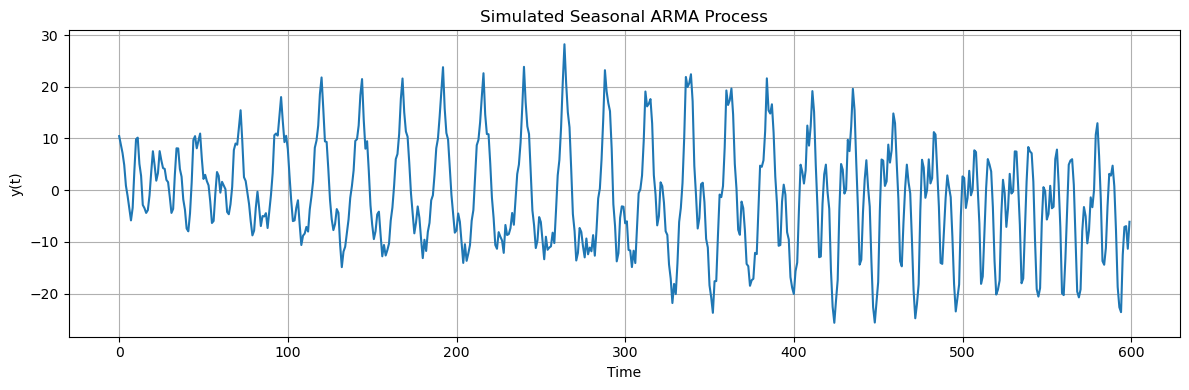

In [23]:
# Define the polynomials
np.random.seed(0)
A = np.array([1, -1.5, 0.7])
A24 = np.array([1] + [0]*23 + [-1])
C24 = np.array([1] + [0]*23 + [-0.5])

A_star = np.convolve(A, A24) # seasonality = 24, dominant season was 24
C_star = np.convolve([1], C24)


# Simulate the process
N = 600
buffer = 100
y = simulate_ARMA(A_star, C, sigma2=1.0, N=N, buffer=buffer)

# Plot the simulated data
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title('Simulated Seasonal ARMA Process')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.grid(True)
plt.tight_layout()
plt.show()



### Basic analysis

Perform basic analysis of the signal using ACF, PACF, and normplot. What characteristics does it have?

Basic Analysis of Seasonal ARMA Process


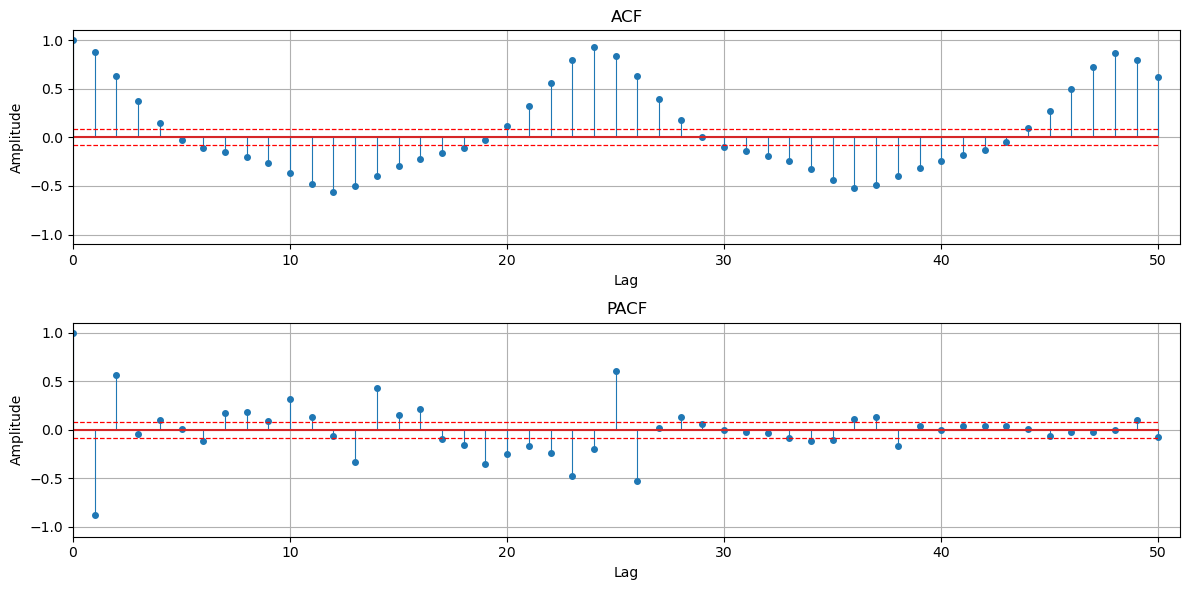

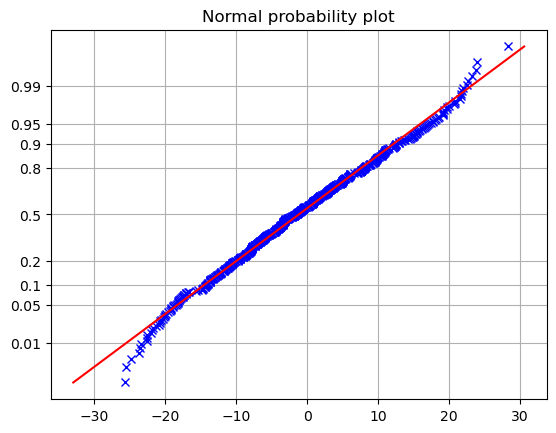

In [22]:
# Basic analysis of the seasonal ARMA data
print("Basic Analysis of Seasonal ARMA Process")
print("=" * 60)

# Plot ACF and PACF
plotACFnPACF(y, noLags=50, signLvl=0.05)

# Check normality
normplot(y)

The ringing behaviour you see in both the ACF and the PACF indicates strong seasonality. To be able to model the process taking the season into account, you create a differentiated process.

### Remove the seasonal component

So to make the data stationary, we remove the seasonal pattern by applying the filter: “remove the seasonal component OR Seasonal Differencing”.

To do so, start by removing the season by filtering the data with $A_{12}(z) = (1 - z^{-12})$.

**Note:** We again have to omit the initial samples - otherwise these initial corrupt samples will harm our continuing processing!

Because seasonal differencing:

- removes the repeating cycle
- stabilizes the variance
- stabilizes the mean
-  makes the series stationary
-  removes the seasonal spikes in ACF
-  allows ARMA estimation on the cleaned data

### Seasonal Differncing lag=24

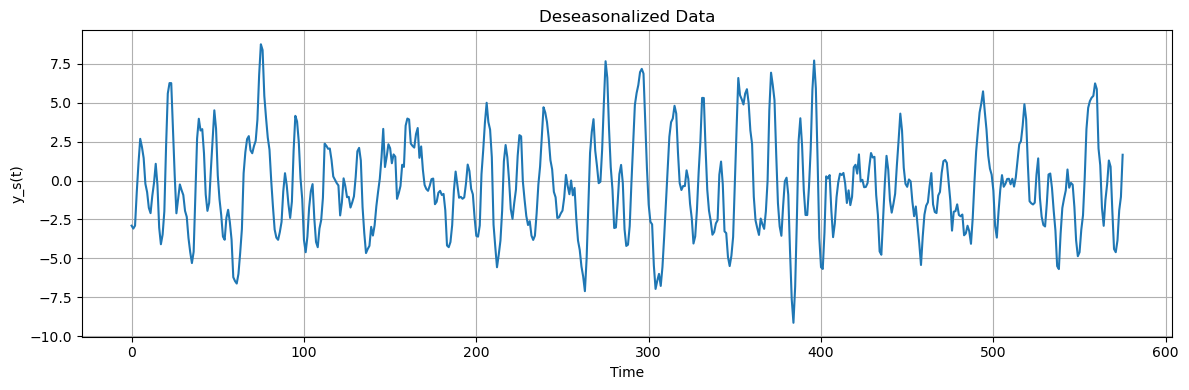

In [30]:
# Remove the seasonal component by filtering with A24(z) = (1 - z^{-24})
# This is equivalent to differencing with lag 24
y_s = my_filter(A24, [1], y)

# Plot the deseasonalized data
plt.figure(figsize=(12, 4))
plt.plot(y_s)
plt.title('Deseasonalized Data')
plt.xlabel('Time')
plt.ylabel('y_s(t)')
plt.grid(True)
plt.tight_layout()
plt.show()

Building a model to this data, one parameter at a time, could
for instance mean starting with an AR(1), as an initial guess, redo the basic
analysis and then proceed to an AR(2)

AR(1) Model on Deseasonalized Data
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.8671(±0.0207)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 50.01%
FPE : 2.272  MSE : 2.265
AIC : 2103.904   BIC : 2108.258


AR(1) Residual Analysis:


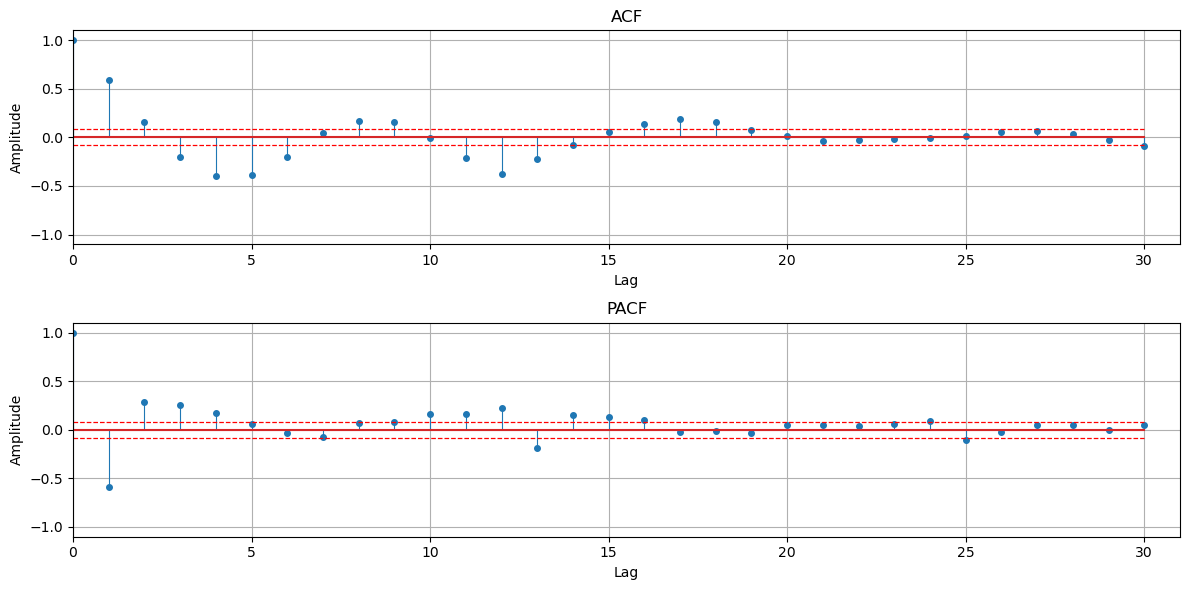

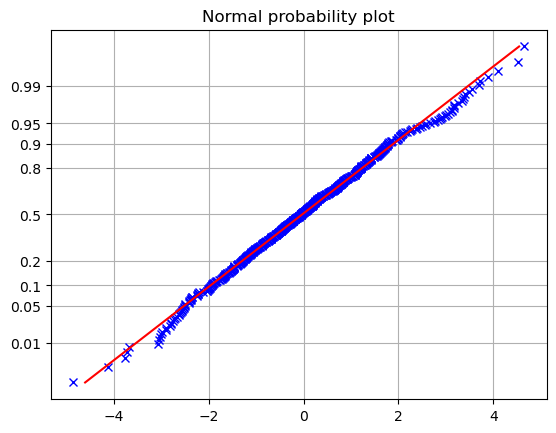


AR(2) Model on Deseasonalized Data
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.4571(±0.0307)·z⁻¹ + 0.6794(±0.0307)·z⁻²

Polynomial orders: nA = 2
Number of free coefficients: 2
Fit to estimation data (NRMSE): 63.23%
FPE : 1.23  MSE : 1.225
AIC : 1749.428   BIC : 1758.134


AR(2) Residual Analysis:


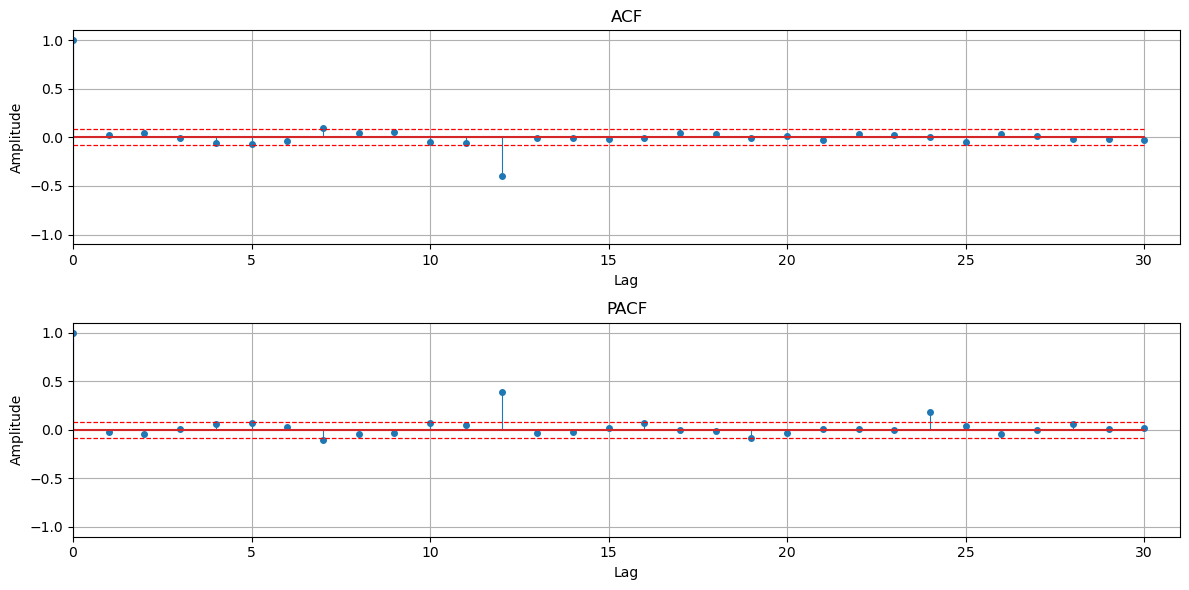

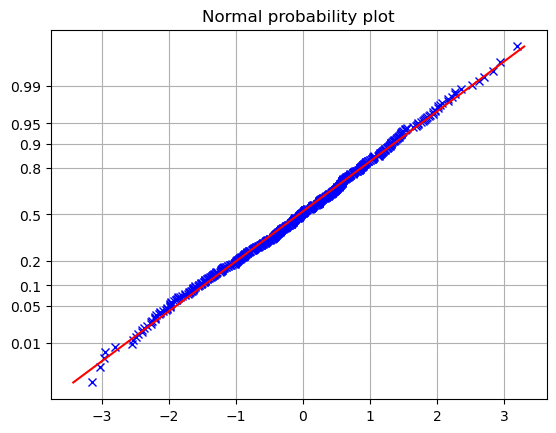

In [31]:
# Create simple AR models for the deseasonalized data

# Start with AR(1)
print("=" * 60)
print("AR(1) Model on Deseasonalized Data")
print("=" * 60)
ar1_model = estimateARMA(y_s, A=1, C=0, plot=False)
ar1_model.summary()

# Compute residuals
e_hat_ar1 = my_filter(ar1_model.A, ar1_model.C, y_s)

# Analyze residuals
print("\nAR(1) Residual Analysis:")
plotACFnPACF(e_hat_ar1, noLags=30, signLvl=0.05)
normplot(e_hat_ar1)

# Now try AR(2)
print("\n" + "=" * 60)
print("AR(2) Model on Deseasonalized Data")
print("=" * 60)
ar2_model = estimateARMA(y_s, A=2, C=0, plot=False)
ar2_model.summary()

# Compute residuals
e_hat_ar2 = my_filter(ar2_model.A, ar2_model.C, y_s)

# Analyze residuals
print("\nAR(2) Residual Analysis:")
plotACFnPACF(e_hat_ar2, noLags=30, signLvl=0.05)
normplot(e_hat_ar2)

Form the residual and plot its ACF and PACF. What characteristics does it have?

AR(2) is the correct non-seasonal model.
Residuals are nearly white → excellent fit.

After seasonal differencing with lag 24, I fit AR models to the deseasonalized series.
AR(2) had much lower FPE and AIC/BIC, clean residuals, and coefficients close to the true values.
**This shows that the non-seasonal part of the SARIMA model is AR(2).**

### Add MA(12) component — the seasonal MA term

To add a single parameter of a higher order, i.e., to set some parameters fixed to a value, we specify which C coefficients are free to be estimated. 

For the C-polynomial, we have thus made all parameters fixed except for $c_{12}$. Include this parameter in the model and estimate $a_1$, $a_2$, and $c_{12}$.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.4617(±0.03)·z⁻¹ + 0.6826(±0.03)·z⁻²
C(z) = 1.0 - 0.4483(±0.0367)·z⁻¹²

Polynomial orders: nA = 2    nC = 12
Number of free coefficients: 3
Fit to estimation data (NRMSE): 66.79%
FPE : 1.005  MSE : 1.007
AIC : 1672.809   BIC : 1685.929



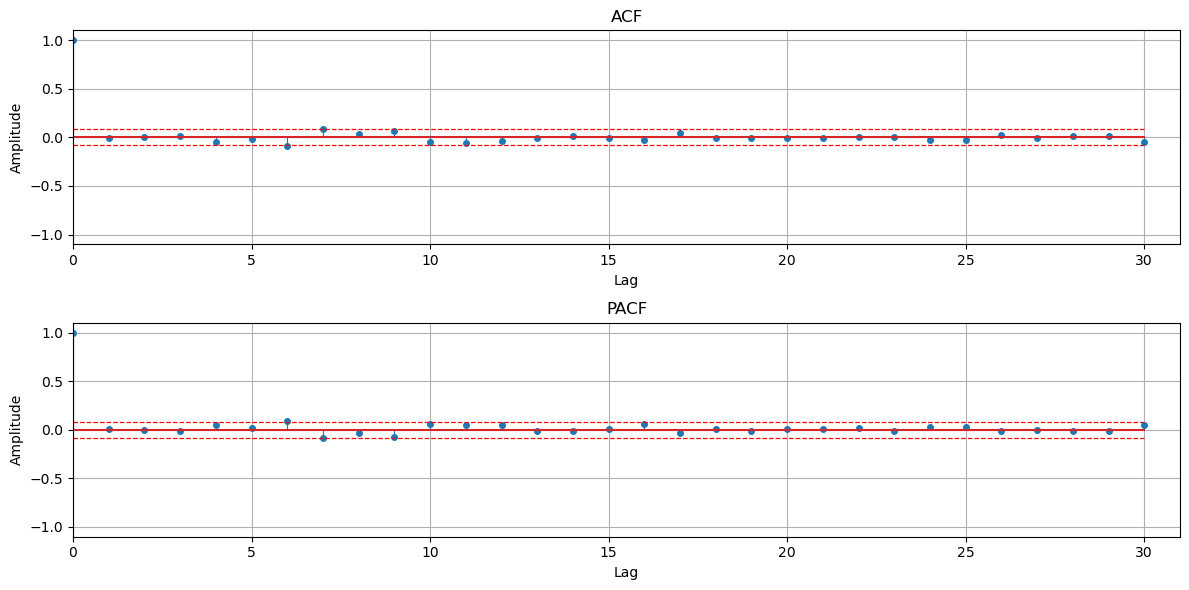

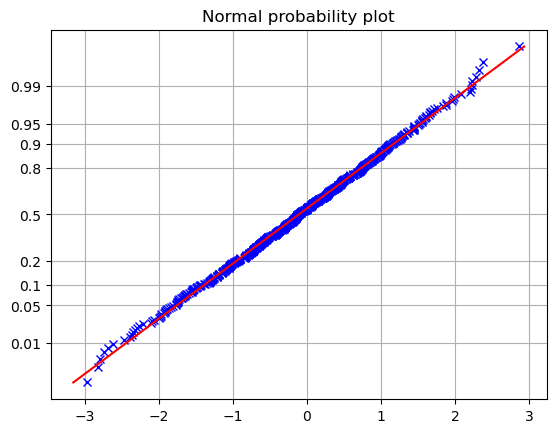

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.53 < 37.65)
  McLeod-Li test:        True (white if 33.81 < 37.65)
  Monti test:            True (white if 23.39 < 37.65)
  Sign change test:      True (white if 0.47 in [0.46,0.54])


In [45]:
# Estimate ARMA(2, 12) with only c_12 free (c_1 through c_11 fixed at 0)
# We specify which C coefficients are free to be estimated
C_free = np.array([1] + [0]*11 + [1])  # c_0 and c_12 are free (c_0 is always 1)

model_arma = estimateARMA(y_s, A=2, C=12, C_free=C_free, plot=False)
model_arma.summary()

# Compute residuals
e_hat_arma = my_filter(model_arma.A, model_arma.C, y_s)

# Analyze residuals
plotACFnPACF(e_hat_arma, noLags=30, signLvl=0.05)
normplot(e_hat_arma)
whiteness_test(e_hat_arma, alpha=0.05)

### Model quality

The main questions to ask are now:

- Did this remove the season of the resulting model residual?
- Is the residual white noise?
- Are the ACF and/or PACF coefficients Gaussian distributed so that you can trust your whiteness test?
- Are the estimated parameters significant?

Compare the estimated parameters with the values used to simulate the process. 

Examine how the quality of the estimates improve if you redo the simulation but instead using $N=10000$ samples.

## Ans  
Yes to all of the above, if we increase N, the parameter estimates become better and confidence intervals narrower. 

### Examination Question 5

**In Mozquizto, answer question 5.**

In [32]:
# Re-simulate with N=10000 samples
np.random.seed(0)
N_large = 10000
buffer = 100

# Simulate the process with 10000 samples
y_large = simulate_ARMA(A_star, C, sigma2=1.0, N=N_large, buffer=buffer, seed=0)

# Remove the seasonal component
y_s_large = my_filter(A12, [1], y_large)

# Estimate AR(2) model on deseasonalized data
ar2_model_large = estimateARMA(y_s_large, A=2, C=0, plot=False)
ar2_model_large.summary()

# Extract a1 coefficient
a1_estimate = ar2_model_large.A[1]
print(f"\nEstimate of a_1 with 10000 samples: {a1_estimate:.2f}")

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.1908(±0.0087)·z⁻¹ + 0.4965(±0.0087)·z⁻²

Polynomial orders: nA = 2
Number of free coefficients: 2
Fit to estimation data (NRMSE): 47.4%
FPE : 1181.726  MSE : 1181.253
AIC : 98987.311   BIC : 99001.729


Estimate of a_1 with 10000 samples: -1.19


### Modelling steps summary

In summary, the typical modelling steps used when constructing a time series model generally works in accordance with the following steps:

1. Is there a trend? Try removing it.
2. Is there any seasonality? Try removing it.
3. Iterate between
   - (a) Which is the lowest order strong AR- or MA-component? Try removing it by including it in the model. Always begin with the strongest AR-component, then inspect the MA-components in the next iteration.
   - (b) Is the residual white noise? If not, go to (a). Can you trust your test, i.e., is the ACF and/or PACF Gaussian distributed? If not, what are the consequences? Should you allow for more parameters?
4. Are all parameter estimates statistically significant? If not, redo the analysis and use a different model structure.

### Hint: Testing with simulated data

**Hint:** If (or, rather, when) you want to check that your code is correct, it is always wise to test it using simulated data, preferably using a lot of samples. 

Simply simulate a process that has roughly the same characteristics as the process you are examining (typically using the model you have estimated) and check that your code predicts the simulated process well. 

For a long sequence, it should work, otherwise, there is most likely a bug somewhere... 

It is highly recommended that you **always** do this when modelling data!

### Discussion: Incorporating differentiation

Can you improve your model by not removing the trend and/or season separately, but rather incorporating these parts in your model and estimate the corresponding coefficients? 

That is, do you get better result if you include the differentiation in your $A(z)$ polynomial? Try it out!

**Question:** Can you incorporate the differentiation $\nabla_{12}$ in the model $A(z)$ instead of first removing the season?

Is the resulting model better in some sense, i.e., is the variance of the model residual lower? 

If you examine the estimated parameters, do they match the internal structure? 

Can you think of any pros and cons of incorporating the differentiation in the model in this way?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

In [ ]:
# Try and have the differentiation in the A() polynomial

## 2.4 Estimation on real data

We now proceed to use our knowledge on estimation of SARIMA-models on real data. Load the temperature measurements from Svedala. Using the working order stated above, create a suitable model for this data. Remember to reestimate all your parameters if you change your model.

In [34]:
import scipy
svedala_file = './data/svedala.mat'
mat_data = scipy.io.loadmat(svedala_file)

print("Keys in .mat file:", mat_data.keys())

svedala = mat_data['svedala'].flatten()
print(f"Loaded {len(svedala)} temperature measurements")
print(f"Data shape: {svedala.shape}")

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'svedala'])
Loaded 1361 temperature measurements
Data shape: (1361,)


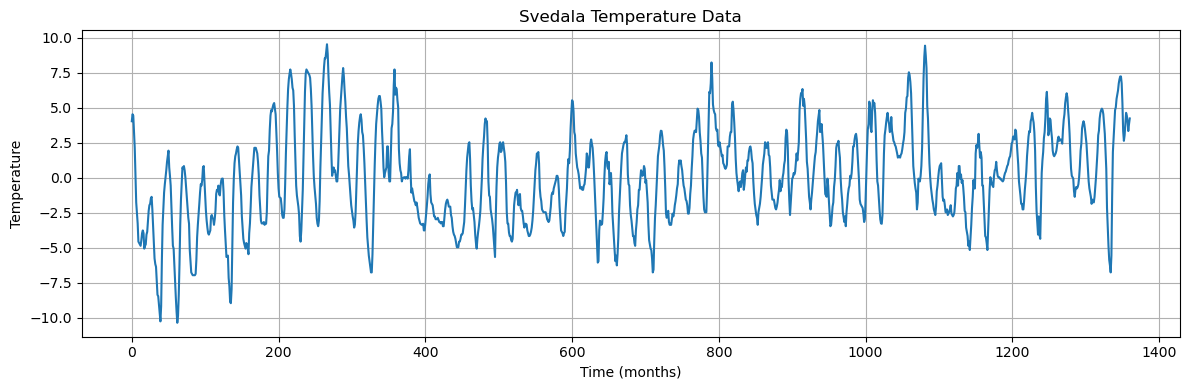

In [35]:
# Plot the data
plt.figure(figsize=(12, 4))
plt.plot(svedala)
plt.title('Svedala Temperature Data')
plt.xlabel('Time (months)')
plt.ylabel('Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

### Basic analysis of Svedala data

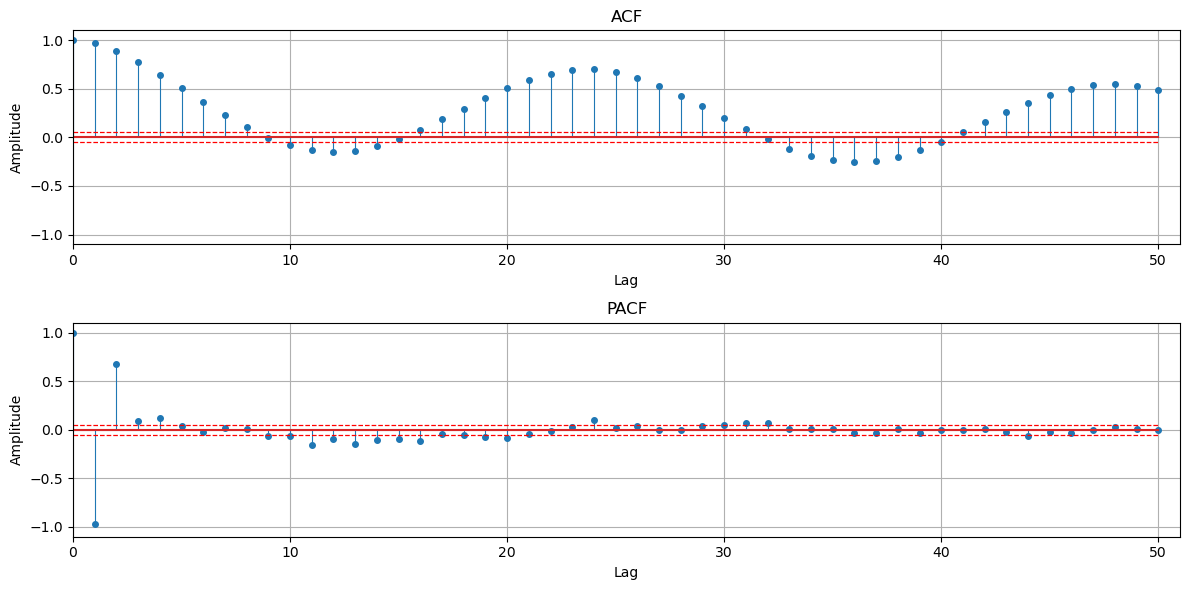

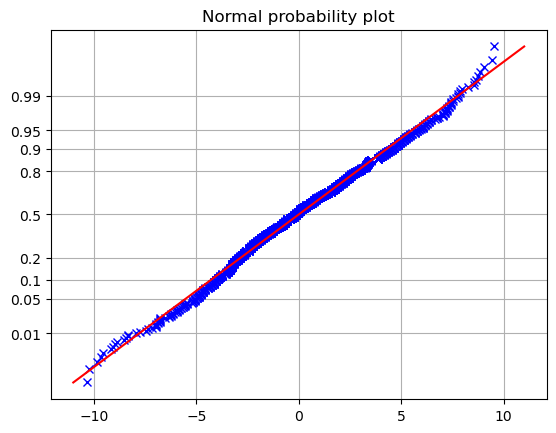

In [36]:
# estimate a model for the Svedala data

plotACFnPACF(svedala, noLags=50, signLvl=0.05)
normplot(svedala)

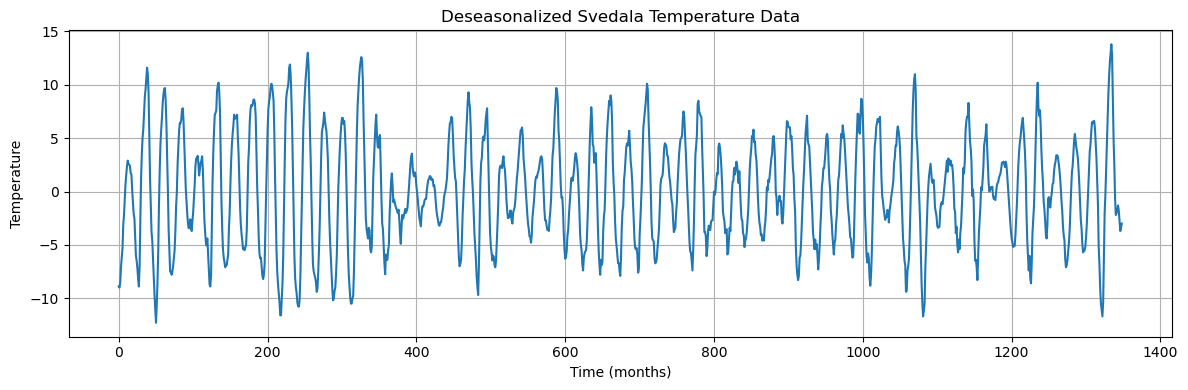


ACF/PACF of Deseasonalized Data:


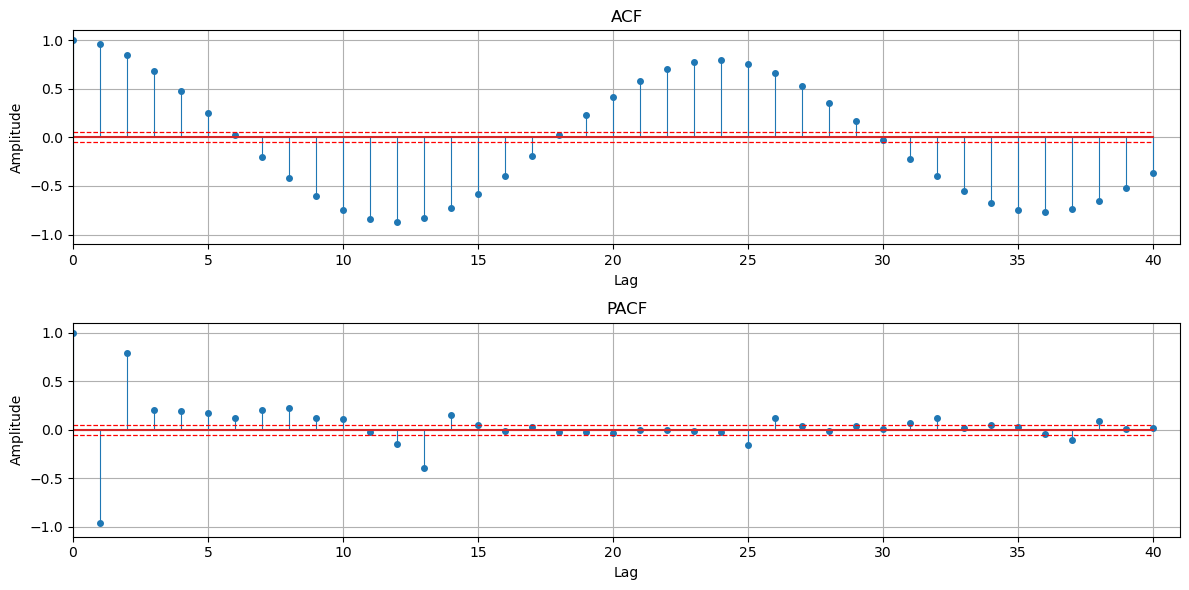


AR(1) Model on Deseasonalized Svedala Data
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.9548(±0.008)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 70.6%
FPE : 2.232  MSE : 2.229
AIC : 4907.696   BIC : 4912.903



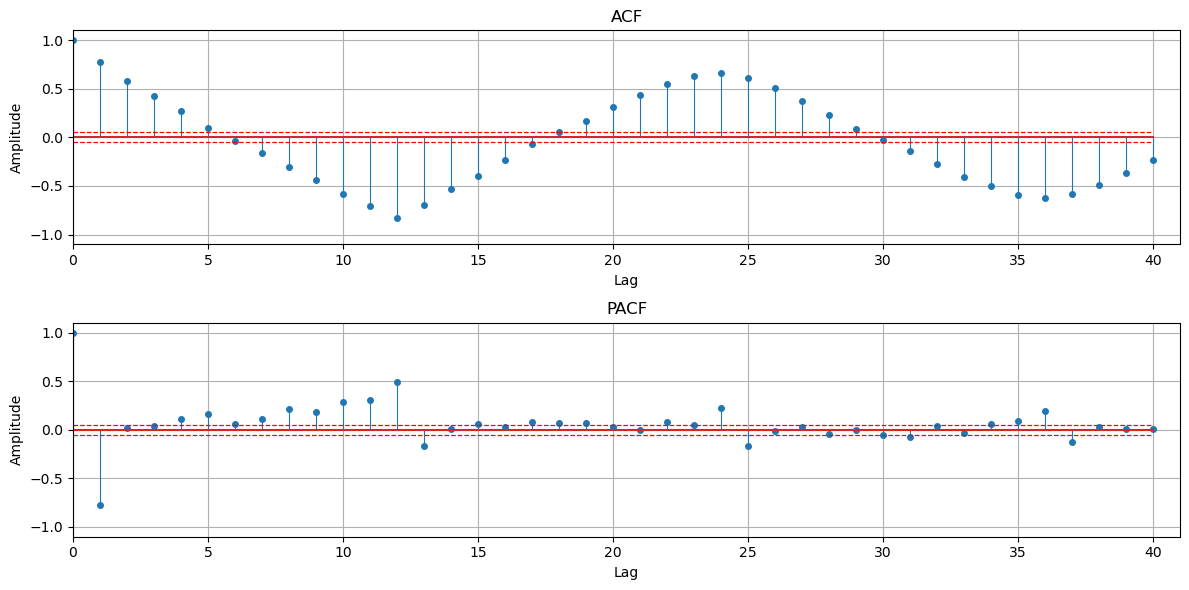

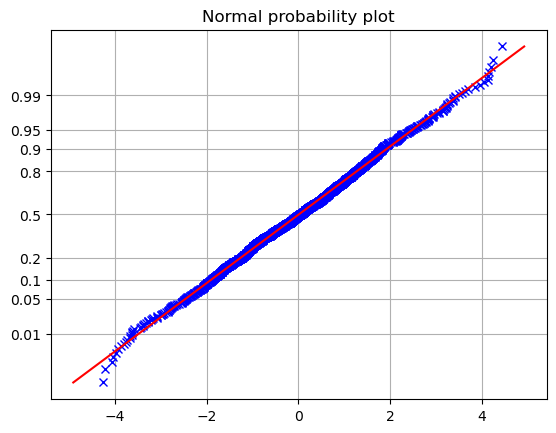


AR(2) Model on Deseasonalized Svedala Data
Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 1.7241(±0.0162)·z⁻¹ + 0.8043(±0.0161)·z⁻²

Polynomial orders: nA = 2
Number of free coefficients: 2
Fit to estimation data (NRMSE): 82.56%
FPE : 0.787  MSE : 0.784
AIC : 3499.446   BIC : 3509.857



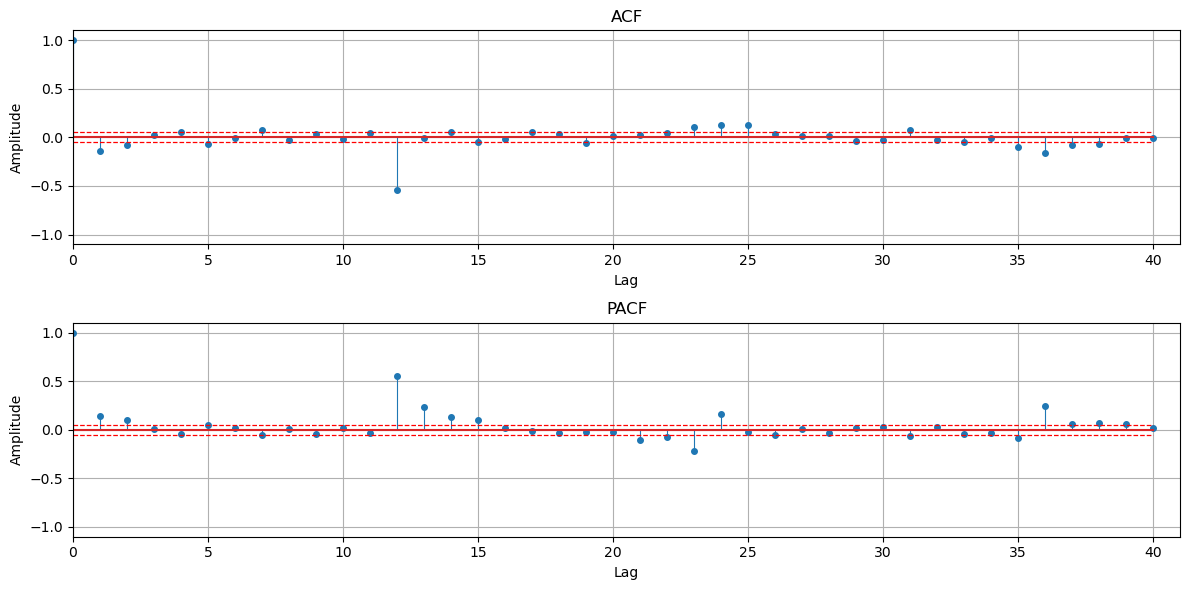

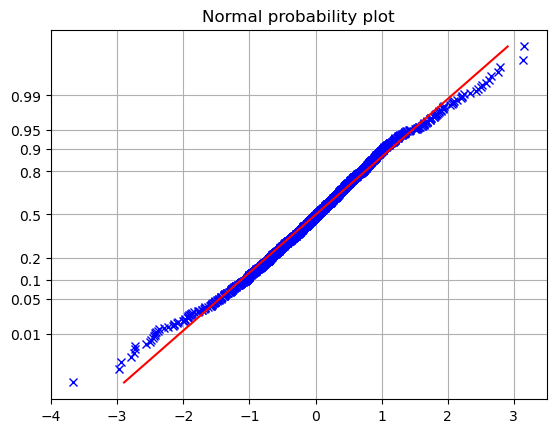

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 546.28 < 37.65)
  McLeod-Li test:        False (white if 304.00 < 37.65)
  Monti test:            False (white if 716.22 < 37.65)
  Sign change test:      True (white if 0.51 in [0.47,0.53])

ARMA(2,12) Model - with c_12 free
Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 1.6346(±0.0192)·z⁻¹ + 0.7118(±0.0192)·z⁻²
C(z) = 1.0 - 0.6462(±0.0195)·z⁻¹²

Polynomial orders: nA = 2    nC = 12
Number of free coefficients: 3
Fit to estimation data (NRMSE): 85.88%
FPE : 0.517  MSE : 0.514
AIC : 2933.456   BIC : 2949.073



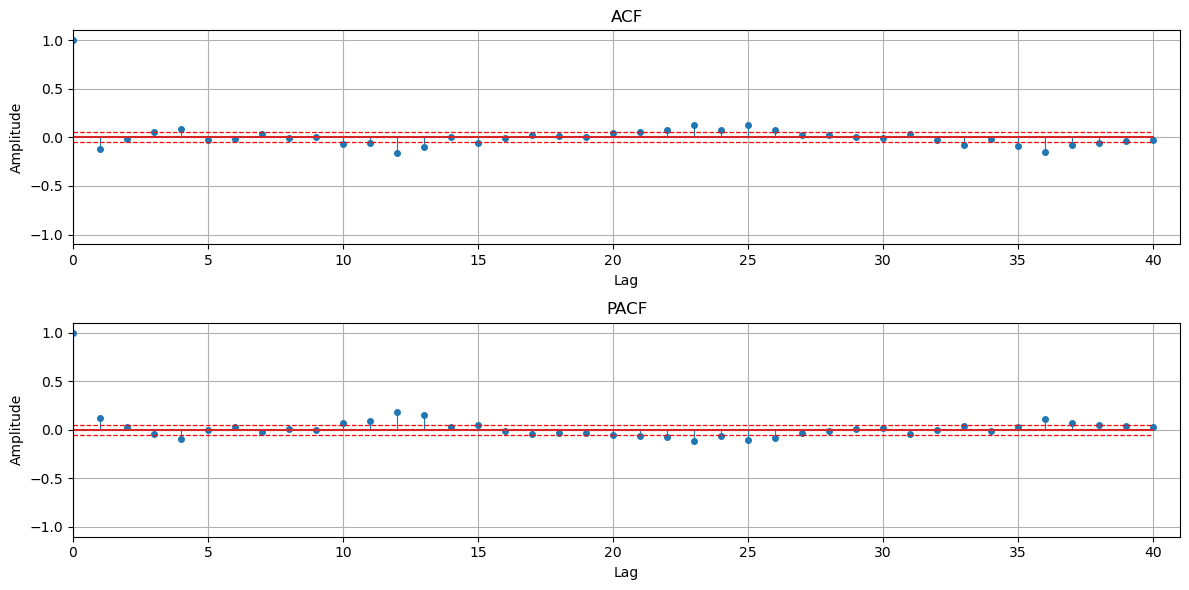

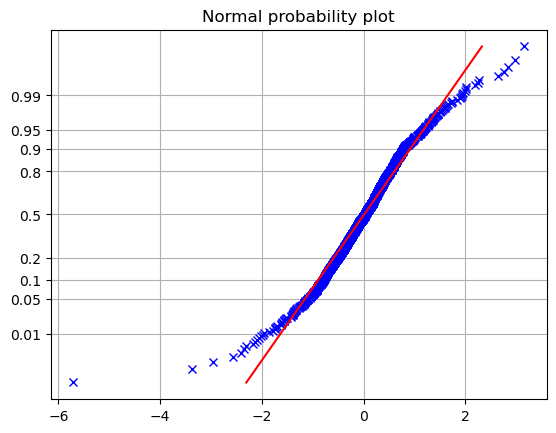

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 167.71 < 37.65)
  McLeod-Li test:        False (white if 164.06 < 37.65)
  Monti test:            False (white if 196.57 < 37.65)
  Sign change test:      True (white if 0.49 in [0.47,0.53])

FINAL MODEL PARAMETERS:
A(z) coefficients: [ 1.         -1.63456145  0.71181572]
C(z) coefficient at lag 12: -0.646227106581158
FPE: 0.5167


In [37]:
# Do some modeling 

# Model the Svedala data following the same approach as section 2.3

# Step 1: Remove seasonal component (seasonal differencing with lag 12)
A12 = np.array([1] + [0]*11 + [-1])
svedala_deseason = my_filter(A12, [1], svedala)

# Plot deseasonalized data
plt.figure(figsize=(12, 4))
plt.plot(svedala_deseason)
plt.title('Deseasonalized Svedala Temperature Data')
plt.xlabel('Time (months)')
plt.ylabel('Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: Check ACF/PACF of deseasonalized data
print("\nACF/PACF of Deseasonalized Data:")
plotACFnPACF(svedala_deseason, noLags=40, signLvl=0.05)

# Step 3: Start with AR(1) model
print("\n" + "=" * 60)
print("AR(1) Model on Deseasonalized Svedala Data")
print("=" * 60)
ar1_svedala = estimateARMA(svedala_deseason, A=1, C=0, plot=False)
ar1_svedala.summary()

e_hat_ar1 = my_filter(ar1_svedala.A, ar1_svedala.C, svedala_deseason)
plotACFnPACF(e_hat_ar1, noLags=40, signLvl=0.05)
normplot(e_hat_ar1)

# Step 4: Try AR(2) model
print("\n" + "=" * 60)
print("AR(2) Model on Deseasonalized Svedala Data")
print("=" * 60)
ar2_svedala = estimateARMA(svedala_deseason, A=2, C=0, plot=False)
ar2_svedala.summary()

e_hat_ar2 = my_filter(ar2_svedala.A, ar2_svedala.C, svedala_deseason)
plotACFnPACF(e_hat_ar2, noLags=40, signLvl=0.05)
normplot(e_hat_ar2)
whiteness_test(e_hat_ar2, alpha=0.05)

# Step 5: Add MA(12) component - ARMA(2,12) with only c_12 free
print("\n" + "=" * 60)
print("ARMA(2,12) Model - with c_12 free")
print("=" * 60)
C_free = np.array([1] + [0]*11 + [1])  # Only c_0 and c_12 are free

arma_svedala = estimateARMA(svedala_deseason, A=2, C=12, C_free=C_free, plot=False)
arma_svedala.summary()

e_hat_arma = my_filter(arma_svedala.A, arma_svedala.C, svedala_deseason)
plotACFnPACF(e_hat_arma, noLags=40, signLvl=0.05)
normplot(e_hat_arma)
whiteness_test(e_hat_arma, alpha=0.05)

print("\n" + "=" * 60)
print("FINAL MODEL PARAMETERS:")
print("=" * 60)
print(f"A(z) coefficients: {arma_svedala.A}")
print(f"C(z) coefficient at lag 12: {arma_svedala.C[12]}")
print(f"FPE: {arma_svedala.FPE:.4f}")

### Examination Question 6

**In Mozquizto, answer question 6.**

What parameter estimates did you get? 

Can you improve the model by not differentiating the data? Why or why not?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

### Discussion: What parameter estimates did you get? Can you improve the model by not differentiating the data? Why or why not?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

## 2.5 (optional) Examine the project data

Why not now load the project data and try to build an ARMA model for the output data? 

Can you make the model residual white without using too many parameters? 

Do you have insignificant parameters in the model? 

Examine the variance of the model residual for the different models - do you need to include all parameters or can you remove some without increasing the variance noticeably while retaining an "almost" white residual?

**Hint:** The above steps will typically be the first part of your work on the project, so the time you spend on this now will be time saved later on...